##### import libraries

In [1]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import LeaveOneOut, GridSearchCV, cross_val_predict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
from sklearn.utils import shuffle

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

##### load features

In [2]:
def load_pickle_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data


coh_base_dir = "../data/COH/"
pli_base_dir = "../data/PLI/"
ste_base_dir = "../data/STE/"


HC_coh  = load_pickle_data(coh_base_dir + "HC_coh_data.pkl")
HC_pli  = load_pickle_data(pli_base_dir + "HC_pli_data.pkl")
MDD_coh = load_pickle_data(coh_base_dir + "MDD_coh_data.pkl")
MDD_pli = load_pickle_data(pli_base_dir + "MDD_pli_data.pkl")
HC_ste  = load_pickle_data(ste_base_dir + "HC_ste_data.pkl")
MDD_ste = load_pickle_data(ste_base_dir + "MDD_ste_data.pkl")

##### feature selection

In [3]:
def combine_features_all(subject_id, coh_dict, pli_dict, ste_dict):
    
    frequency_bands = ["delta", "theta", "alpha", "betalow", "betahigh", "gamma"]
    features = []
    # COH
    for band in frequency_bands:
        features.append(coh_dict[subject_id][band])
    # PLI
    for band in frequency_bands:
        features.append(pli_dict[subject_id][band])
    # STE
    for band in frequency_bands:
        matrix = ste_dict[subject_id][band] 
        mask = np.ones(matrix.shape, dtype=bool)
        np.fill_diagonal(mask, False)
        vector = matrix[mask] 
        features.append(vector)
    return np.concatenate(features)

In [4]:
HC_subjects = sorted(HC_coh.keys())
MDD_subjects = sorted(MDD_coh.keys())


n_train_HC = 45
n_train_MDD = 45

HC_train_ids = HC_subjects[:n_train_HC]
HC_test_ids  = HC_subjects[n_train_HC:]
MDD_train_ids = MDD_subjects[:n_train_MDD]
MDD_test_ids  = MDD_subjects[n_train_MDD:]

In [5]:
X_train_list = []
y_train_list = []
train_ids = []

for subj in HC_train_ids:
    feat_vector = combine_features_all(subj, HC_coh, HC_pli, HC_ste)
    X_train_list.append(feat_vector)
    y_train_list.append(0)    # HC = 0
    train_ids.append(subj)
for subj in MDD_train_ids:
    feat_vector = combine_features_all(subj, MDD_coh, MDD_pli, MDD_ste)
    X_train_list.append(feat_vector)
    y_train_list.append(1)    # MDD = 1
    train_ids.append(subj)

X_train = np.array(X_train_list)  # shape: (90, 9744)
y_train = np.array(y_train_list)
print("Training set data shape:", X_train.shape, y_train.shape)

Training set data shape: (90, 9744) (90,)


In [6]:
X_test_list = []
y_test_list = []
test_ids = []

for subj in HC_test_ids:
    feat_vector = combine_features_all(subj, HC_coh, HC_pli, HC_ste)
    X_test_list.append(feat_vector)
    y_test_list.append(0)
    test_ids.append(subj)
for subj in MDD_test_ids:
    feat_vector = combine_features_all(subj, MDD_coh, MDD_pli, MDD_ste)
    X_test_list.append(feat_vector)
    y_test_list.append(1)
    test_ids.append(subj)

X_test = np.array(X_test_list)    # shape: (39, 9744)
y_test = np.array(y_test_list)
print("Independent test set data shape:", X_test.shape, y_test.shape)

Independent test set data shape: (46, 9744) (46,)


In [7]:
def compute_fisher_scores(X, y, eps=1e-12):
    N = len(y)
    n_class0 = np.sum(y == 0)
    n_class1 = np.sum(y == 1)
    p0 = n_class0 / N
    p1 = n_class1 / N
    m_global = np.mean(X, axis=0)
    X0 = X[y == 0]
    X1 = X[y == 1]
    m0 = np.mean(X0, axis=0)
    m1 = np.mean(X1, axis=0)
    var0 = np.var(X0, axis=0)
    var1 = np.var(X1, axis=0)
    S_B = p0 * (m0 - m_global) ** 2 + p1 * (m1 - m_global) ** 2
    S_W = p0 * var0 + p1 * var1
    return S_B / (S_W + eps)

fscores = compute_fisher_scores(X_train, y_train)


In [8]:
top_100_idx = np.argsort(fscores)[-100:]
top_100_idx = top_100_idx[np.argsort(fscores[top_100_idx])[::-1]]

X_train_reduced = X_train[:, top_100_idx]
X_test_reduced  = X_test[:, top_100_idx]
print("Training set after Fisher selection:", X_train_reduced.shape)
print("Independent test set after Fisher selection:", X_test_reduced.shape)

Training set after Fisher selection: (90, 100)
Independent test set after Fisher selection: (46, 100)


In [9]:
top_10_idx = np.argsort(fscores)[-50:]
top_10_idx = top_10_idx[np.argsort(fscores[top_10_idx])[::-1]]

X_train_reduced = X_train[:, top_10_idx]
X_test_reduced  = X_test[:, top_10_idx]
print("Training set after Fisher selection:", X_train_reduced.shape)
print("Independent test set after Fisher selection:", X_test_reduced.shape)

Training set after Fisher selection: (90, 50)
Independent test set after Fisher selection: (46, 50)


##### load history

In [10]:
with open("../result/MDD_HC/best_overall_10.pkl", "rb") as f:
    best_overall = pickle.load(f)

with open("../result/MDD_HC/sfs_history.pkl", "rb") as f:
    sfs_history = pickle.load(f)

with open("../result/MDD_HC/sfs_test_history.pkl", "rb") as f:
    sfs_test_history = pickle.load(f)


final_subset = best_overall["subset"]
print("\n[SFS] Optimal feature subset (Fisher candidate indices):", final_subset)


X_train_final = X_train_reduced[:, final_subset]
X_test_final  = X_test_reduced[:, final_subset]
print("Final training set shape (SFS):", X_train_final.shape)
print("Final independent test set shape (SFS):", X_test_final.shape)


[SFS] Optimal feature subset (Fisher candidate indices): [6, 75, 3, 7, 2, 11, 9, 26, 90, 1]
Final training set shape (SFS): (90, 10)
Final independent test set shape (SFS): (46, 10)


In [9]:
# top 10 fisher features
X_train_final = X_train_reduced.copy()
X_test_final  = X_test_reduced.copy()

##### cVAE design

In [10]:
class cVAE(nn.Module):
    def __init__(self, input_dim=33, latent_dim=10, num_classes=2):
        
        super(cVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # --- Encoder ---
        self.conv1d_enc = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc_enc = nn.Sequential(
            nn.Linear(64 * input_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        
        # --- Decoder ---
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc_dec_final = nn.Linear(256, 64 * input_dim)
        self.conv1d_dec = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=8, out_channels=1, kernel_size=3, padding=1)
        )
        
    def encode(self, x, c):
        x = x.unsqueeze(1)                  # (B, 1, input_dim)
        x = self.conv1d_enc(x)              # (B, 64, input_dim)
        x = x.view(x.size(0), -1)           # (B, 64*input_dim)
        x = torch.cat([x, c], dim=1)        # (B, 64*input_dim + num_classes)
        h = self.fc_enc(x)                  # (B, 32)
        mu = self.fc_mu(h)                  # (B, latent_dim)
        logvar = self.fc_logvar(h)          # (B, latent_dim)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)    # (B, latent_dim + num_classes)
        h = self.fc_dec(z_cond)              # (B, 256)
        h = self.fc_dec_final(h)             # (B, 64*input_dim)
        h = h.view(-1, 64, self.input_dim)   # (B, 64, input_dim)
        x_recon = self.conv1d_dec(h)         # (B, 1, input_dim)
        x_recon = x_recon.squeeze(1)         # (B, input_dim)
        return x_recon
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar, z

##### FC VAE

In [ ]:
class cVAE(nn.Module):
    def __init__(self, input_dim=33, latent_dim=10, num_classes=2):
        super(cVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes


        self.fc_enc = nn.Sequential(
            nn.Linear(input_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)


        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.fc_dec_final = nn.Linear(256, input_dim)

    def encode(self, x, c):
        # x: (B, input_dim), c: (B, num_classes)
        x_cond = torch.cat([x, c], dim=1)    # (B, input_dim + num_classes)
        h = self.fc_enc(x_cond)             # (B, 32)
        mu = self.fc_mu(h)                  # (B, latent_dim)
        logvar = self.fc_logvar(h)          # (B, latent_dim)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        # z: (B, latent_dim), c: (B, num_classes)
        z_cond = torch.cat([z, c], dim=1)   # (B, latent_dim + num_classes)
        h = self.fc_dec(z_cond)             # (B, 256)
        x_recon = self.fc_dec_final(h)      # (B, input_dim)
        return x_recon

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar, z

##### info VAE design

In [12]:
def compute_kernel(x, y):
    x_size, y_size, dim = x.size(0), y.size(0), x.size(1)
    x = x.unsqueeze(1)  # (x_size,1,dim)
    y = y.unsqueeze(0)  # (1,y_size,dim)
    dist = ((x - y) ** 2).sum(2)  # (x_size,y_size)
    bandwidths = [10, 20, 40, 80, 160]
    kernel = sum(torch.exp(-dist / bw) for bw in bandwidths)
    return kernel

def mmd_loss(z):
    prior = torch.randn_like(z)
    K_zz = compute_kernel(z, z)
    K_pp = compute_kernel(prior, prior)
    K_zp = compute_kernel(z, prior)
    return K_zz.mean() + K_pp.mean() - 2 * K_zp.mean()

def loss_function_infovae(recon_x, x, mu, logvar, z,
                          input_dim, alpha=1.0, lambda_mmd=10.0):
    rec_loss = nn.functional.mse_loss(recon_x, x, reduction="mean") * input_dim

    kl_div   = -0.5 * torch.mean(
        torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    )
    # MMD
    mmd = mmd_loss(z)
    # InfoVAE loss
    return rec_loss + (1 - alpha) * kl_div + (alpha + lambda_mmd - 1) * mmd




def train_info_vae(model, train_loader, val_loader=None,
                   epochs=100, lr=1e-3, input_dim=33,
                   early_stopping=False, patience=10, plot_losses=False):
    optimizer    = optim.Adam(model.parameters(), lr=lr)
    best_val_loss, no_improve = float('inf'), 0
    train_losses, val_losses   = [], []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        model.train()
        tloss = 0
        for bx, bc in train_loader:
            optimizer.zero_grad()
            recon, mu, logvar, z = model(bx, bc)
            loss = loss_function_infovae(
                recon, bx, mu, logvar, z,
                input_dim, alpha=0.5, lambda_mmd=1                            ### modify this parameter
            )
            loss.backward()
            optimizer.step()
            tloss += loss.item() * bx.size(0)
        train_losses.append(tloss / len(train_loader.dataset))

        if val_loader:
            model.eval()
            vloss = 0
            with torch.no_grad():
                for vx, vc in val_loader:
                    recon, mu, logvar, z = model(vx, vc)
                    l = loss_function_infovae(
                        recon, vx, mu, logvar, z,
                        input_dim, alpha=1.0, lambda_mmd=10.0
                    )
                    vloss += l.item() * vx.size(0)
            val_loss = vloss / len(val_loader.dataset)
            val_losses.append(val_loss)
            if early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss, no_improve = val_loss, 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break

    if plot_losses:
        sns.reset_defaults()
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Train Loss')
        if val_losses:
            plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return model

##### function design

In [ ]:
def loss_function_vae(recon_x, x, mu, logvar, input_dim, beta=1.0):
    rec_loss = nn.functional.mse_loss(recon_x, x, reduction="mean") * input_dim
    kl_div = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    total = rec_loss + beta * kl_div
    return total, rec_loss.item(), kl_div.item()

In [11]:
def loss_function_vae(recon_x, x, mu, logvar, input_dim, beta=1.0):
    rec_loss = nn.functional.mse_loss(recon_x, x, reduction="mean") * input_dim
    kl_div = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl_div = kl_div.mean()
    total = rec_loss + beta * kl_div 
    return total, rec_loss.item(), kl_div.item()

##### train w/o annealing

In [12]:
def train_info_vae(model,
                   train_loader,
                   val_loader=None,
                   epochs=100,
                   lr=1e-3,
                   input_dim=100,
                   beta=1.0,
                   early_stopping=False,
                   patience=10,
                   plot_losses=False,
                   plot_components=False):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss, no_improve = float('inf'), 0
    train_total, train_rec, train_kl = [], [], []
    val_losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        model.train()
        t_loss = r_loss = k_loss = 0.0

        for bx, bc in train_loader:
            optimizer.zero_grad()
            recon, mu, logvar, z = model(bx, bc)
            loss, rec_l, kl_l = loss_function_vae(recon, bx, mu, logvar, input_dim, beta)
            loss.backward()
            optimizer.step()

            bsz = bx.size(0)
            t_loss += loss.item() * bsz
            r_loss += rec_l * bsz
            k_loss += kl_l * bsz

        n = len(train_loader.dataset)
        train_total.append(t_loss / n)
        train_rec.append(r_loss / n)
        train_kl.append(k_loss / n)

        if val_loader:
            model.eval()
            v_loss = 0.0
            with torch.no_grad():
                for vx, vc in val_loader:
                    recon, mu, logvar, z = model(vx, vc)
                    loss, _, _ = loss_function_vae(recon, vx, mu, logvar, input_dim, beta)
                    v_loss += loss.item() * vx.size(0)
            val_losses.append(v_loss / len(val_loader.dataset))

            if early_stopping:
                if val_losses[-1] < best_val_loss:
                    best_val_loss, no_improve = val_losses[-1], 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        print(f"Early stop at epoch {epoch+1}")
                        break

    # Plot total loss
    if plot_losses:
        sns.reset_defaults()
        plt.figure(figsize=(12, 6))
        plt.plot(train_total, label='Train Total Loss', linewidth=2)
        if val_losses:
            plt.plot(val_losses, label='Val Total Loss', linewidth=2)
        plt.title('Total Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(which='major', linestyle='--', alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', alpha=0.4)
        plt.tight_layout()
        plt.show()

    # Plot loss components
    if plot_components:
        sns.reset_defaults()
        plt.figure(figsize=(12, 6))
        plt.plot(train_rec, label='Reconstruction Loss', linewidth=2)
        plt.plot(train_kl,  label='KL Divergence',       linewidth=2)
        plt.title('Loss Components Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.legend()
        plt.grid(which='major', linestyle='--', alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', alpha=0.4)
        plt.tight_layout()
        plt.show()

    return model


def generate_samples_pt(model, n_samples, latent_dim, c):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        generated = model.decode(z, c)
    return generated.cpu().numpy()



def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

##### train w/ annealing

In [12]:
# Annealing

def train_info_vae(model,
                   train_loader,
                   val_loader=None,
                   epochs=100,
                   lr=1e-3,
                   input_dim=100,
                   beta=1.0,
                   early_stopping=False,
                   patience=10,
                   plot_losses=False,
                   plot_components=False):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss, no_improve = float('inf'), 0
    train_total, train_rec, train_kl = [], [], []
    val_losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        model.train()
        t_loss = r_loss = k_loss = 0.0

        
        if epochs > 1:
            current_beta = beta * (epoch / (epochs - 1))
        else:
            current_beta = beta



        for bx, bc in train_loader:
            optimizer.zero_grad()
            recon, mu, logvar, z = model(bx, bc)
            loss, rec_l, kl_l = loss_function_vae(
                recon, bx, mu, logvar, input_dim, current_beta
            )
            loss.backward()
            optimizer.step()

            bsz = bx.size(0)
            t_loss += loss.item() * bsz
            r_loss += rec_l * bsz
            k_loss += kl_l * bsz

        n = len(train_loader.dataset)
        train_total.append(t_loss / n)
        train_rec.append(r_loss / n)
        train_kl.append(k_loss / n)

        if val_loader is not None:
            model.eval()
            v_loss = 0.0
            with torch.no_grad():
                for vx, vc in val_loader:
                    recon, mu, logvar, z = model(vx, vc)
                    loss, _, _ = loss_function_vae(
                        recon, vx, mu, logvar, input_dim, current_beta
                    )
                    v_loss += loss.item() * vx.size(0)
            val_losses.append(v_loss / len(val_loader.dataset))

            if early_stopping:
                if val_losses[-1] < best_val_loss:
                    best_val_loss, no_improve = val_losses[-1], 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        print(f"Early stop at epoch {epoch + 1}")
                        break

    # Plot total loss
    if plot_losses:
        sns.reset_defaults()
        plt.figure(figsize=(12, 6))
        plt.plot(train_total, label='Train Total Loss', linewidth=2)
        if val_losses:
            plt.plot(val_losses, label='Val Total Loss', linewidth=2)
        plt.title('Total Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(which='major', linestyle='--', alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', alpha=0.4)
        plt.tight_layout()
        plt.show()

    # Plot loss components
    if plot_components:
        sns.reset_defaults()
        plt.figure(figsize=(12, 6))
        plt.plot(train_rec, label='Reconstruction Loss', linewidth=2)
        plt.plot(train_kl,  label='KL Divergence',       linewidth=2)
        plt.title('Loss Components Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.legend()
        plt.grid(which='major', linestyle='--', alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', alpha=0.4)
        plt.tight_layout()
        plt.show()

    return model


def generate_samples_pt(model, n_samples, latent_dim, c):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        generated = model.decode(z, c)
    return generated.cpu().numpy()


def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)


##### training params

In [13]:
latent_dim_pt = 15
num_classes = 2
epochs_pt = 100
dummy_input_dim = X_train_final.shape[1]

##### training w/o validation

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


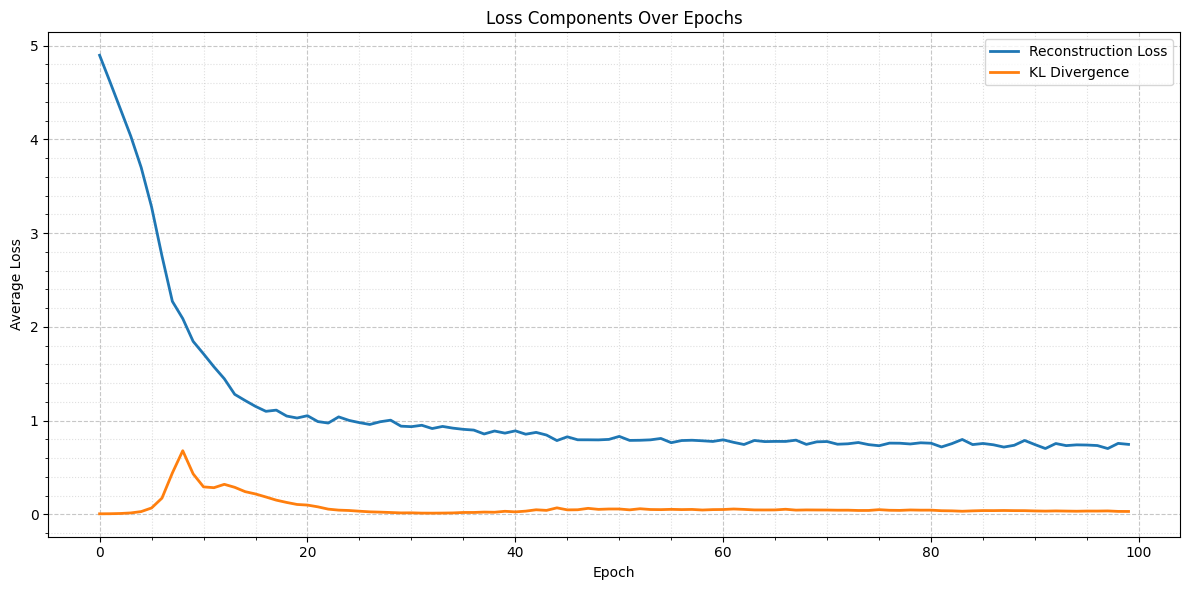

In [ ]:
X_t = torch.tensor(X_train_final, dtype=torch.float32)
y_t = torch.tensor(y_train, dtype=torch.long)
cond = nn.functional.one_hot(y_t, num_classes=2).float()


full_dataset = TensorDataset(X_t, cond)
train_loader = DataLoader(full_dataset, batch_size=16, shuffle=True)



vae = cVAE(input_dim=dummy_input_dim, latent_dim=latent_dim_pt, num_classes=num_classes)
vae = train_info_vae(
    model=vae,
    train_loader=train_loader,
    val_loader=None,
    epochs=epochs_pt,
    lr=1e-4,                             ## modify this parameter
    input_dim=dummy_input_dim,
    beta=2,                              ## modify this parameter
    early_stopping=True,
    patience=20,                         
    plot_losses=False,
    plot_components=True
)


##### training w/ validation

In [ ]:
X_t = torch.tensor(X_train_final, dtype=torch.float32)
y_t = torch.tensor(y_train, dtype=torch.long)
cond = nn.functional.one_hot(y_t, num_classes=2).float()


full_dataset = TensorDataset(X_t, cond)
n_total = len(full_dataset)
n_val   = int(n_total*0.2)
n_train = n_total - n_val

train_dataset, val_dataset = random_split(
    full_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(43)
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)




dummy_input_dim = X_train_final.shape[1]
vae = cVAE(input_dim=dummy_input_dim, latent_dim=latent_dim_pt, num_classes=2)

vae = train_info_vae(
    model=vae,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs_pt,
    lr=1e-3,
    input_dim=dummy_input_dim,
    early_stopping=True,
    patience=20,
    plot_losses=True
)


##### sampling (accumulate)

In [26]:
def generate_samples(model, n_samples, latent_dim, cond):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        return model.decode(z, cond).cpu().numpy()


param_grid = [
    {'kernel': ['rbf'], 'C': [0.1,1,10,100,1000],
     'gamma': [1.05**e for e in range(-100,101,10)]},
    {'kernel': ['linear'], 'C': [0.1,1,10,100,1000]}
]
cv_loocv = LeaveOneOut()


gen_step   = 50
gen_counts = list(range(gen_step, 500 + gen_step, gen_step))


all_generated     = {}
loocv_scores      = []
test_scores       = []
best_params_all   = []


feature_dim = X_train_final.shape[1]
synth0_total = np.zeros((0, feature_dim))
synth1_total = np.zeros((0, feature_dim))

for r in gen_counts:

    cond0_new = torch.zeros(gen_step, 2); cond0_new[:,0] = 1
    cond1_new = torch.zeros(gen_step, 2); cond1_new[:,1] = 1
    new_synth0 = generate_samples(vae, gen_step, latent_dim_pt, cond0_new)
    new_synth1 = generate_samples(vae, gen_step, latent_dim_pt, cond1_new)


    synth0_total = np.vstack([synth0_total, new_synth0])
    synth1_total = np.vstack([synth1_total, new_synth1])


    all_generated[r] = {
        'synth0': synth0_total.copy(),
        'synth1': synth1_total.copy()
    }


    X_aug = np.vstack([X_train_final,
                       synth0_total,
                       synth1_total])
    y_aug = np.concatenate([y_train,
                            np.zeros(len(synth0_total)),
                            np.ones(len(synth1_total))])

    # LOOCV GridSearch
    grid = GridSearchCV(
        SVC(), param_grid,
        scoring="accuracy",
        cv=cv_loocv, n_jobs=-1
    )
    grid.fit(X_aug, y_aug)
    loocv_acc = grid.best_score_
    best_p    = grid.best_params_


    clf      = SVC(**best_p).fit(X_aug, y_aug)
    test_acc = accuracy_score(
        y_test,
        clf.predict(X_test_final)
    )


    loocv_scores.append(loocv_acc)
    test_scores.append(test_acc)
    best_params_all.append(best_p)

    print(f"r={r:4d} | LOOCV Acc: {loocv_acc:.4f} | Test Acc: {test_acc:.4f}")

r=  50 | LOOCV Acc: 0.9632 | Test Acc: 0.8205
r= 100 | LOOCV Acc: 0.9759 | Test Acc: 0.8205
r= 150 | LOOCV Acc: 0.9821 | Test Acc: 0.8205
r= 200 | LOOCV Acc: 0.9837 | Test Acc: 0.8205
r= 250 | LOOCV Acc: 0.9847 | Test Acc: 0.8205


KeyboardInterrupt: 

##### sampling (random)

In [58]:
def generate_samples(model, n_samples, latent_dim, cond):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim)
        return model.decode(z, cond).cpu().numpy()

param_grid = [
    {'kernel': ['rbf'], 'C': [0.1,1,10,100,1000],
     'gamma': [1.05**e for e in range(-100,101,10)]},
    {'kernel': ['linear'], 'C': [0.1,1,10,100,1000]}
]
cv_loocv = LeaveOneOut()

gen_counts = list(range(10, 251, 10))

# dictionary to hold all synthetic samples
all_generated = {}

loocv_scores, test_scores, best_params_all = [], [], []

for r in gen_counts:
    # generate synthetic for class 0 & 1
    cond0 = torch.zeros(r, 2); cond0[:,0] = 1
    cond1 = torch.zeros(r, 2); cond1[:,1] = 1
    synth0 = generate_samples(vae, r, latent_dim_pt, cond0)
    synth1 = generate_samples(vae, r, latent_dim_pt, cond1)

    # store in dict
    all_generated[r] = {
        'synth0': synth0,
        'synth1': synth1
    }

    # augment
    X_aug = np.vstack([X_train_final, synth0, synth1])
    y_aug = np.concatenate([y_train,
                            np.zeros(r),
                            np.ones(r)])

    # LOOCV GridSearch
    grid = GridSearchCV(SVC(), param_grid,
                        scoring="accuracy",
                        cv=cv_loocv, n_jobs=-1)
    grid.fit(X_aug, y_aug)
    loocv_acc = grid.best_score_
    best_p    = grid.best_params_

    # independent test
    clf = SVC(**best_p).fit(X_aug, y_aug)
    test_acc = accuracy_score(y_test,
                              clf.predict(X_test_final))

    loocv_scores.append(loocv_acc)
    test_scores.append(test_acc)
    best_params_all.append(best_p)

    print(f"r={r:4d} | LOOCV Acc: {loocv_acc:.4f} | Test Acc: {test_acc:.4f}")


r=  10 | LOOCV Acc: 0.8636 | Test Acc: 0.8043
r=  20 | LOOCV Acc: 0.8615 | Test Acc: 0.7826
r=  30 | LOOCV Acc: 0.8800 | Test Acc: 0.8043
r=  40 | LOOCV Acc: 0.8824 | Test Acc: 0.7609
r=  50 | LOOCV Acc: 0.9000 | Test Acc: 0.8043
r=  60 | LOOCV Acc: 0.9143 | Test Acc: 0.8043
r=  70 | LOOCV Acc: 0.9174 | Test Acc: 0.8043
r=  80 | LOOCV Acc: 0.9280 | Test Acc: 0.8043
r=  90 | LOOCV Acc: 0.9222 | Test Acc: 0.8043
r= 100 | LOOCV Acc: 0.9345 | Test Acc: 0.7826
r= 110 | LOOCV Acc: 0.9323 | Test Acc: 0.7826
r= 120 | LOOCV Acc: 0.9485 | Test Acc: 0.8043
r= 130 | LOOCV Acc: 0.9457 | Test Acc: 0.8043
r= 140 | LOOCV Acc: 0.9324 | Test Acc: 0.7826
r= 150 | LOOCV Acc: 0.9513 | Test Acc: 0.8043
r= 160 | LOOCV Acc: 0.9439 | Test Acc: 0.8261
r= 170 | LOOCV Acc: 0.9512 | Test Acc: 0.7826
r= 180 | LOOCV Acc: 0.9578 | Test Acc: 0.8043
r= 190 | LOOCV Acc: 0.9489 | Test Acc: 0.8043
r= 200 | LOOCV Acc: 0.9510 | Test Acc: 0.8043
r= 210 | LOOCV Acc: 0.9569 | Test Acc: 0.8043
r= 220 | LOOCV Acc: 0.9528 | Test 

##### save result

In [64]:
with open("../result/MDD_HC/BVAE/B=2/all_generated_samples.pkl", "wb") as f:
    pickle.dump(all_generated, f)

# save LOOCV/test history
with open("../result/MDD_HC/BVAE/B=2/svm_loocv_test_history.pkl", "wb") as f:
    pickle.dump({
        "gen_counts": gen_counts,
        "loocv_scores": loocv_scores,
        "test_scores": test_scores,
        "best_params": best_params_all
    }, f)

##### plot accuracy curve

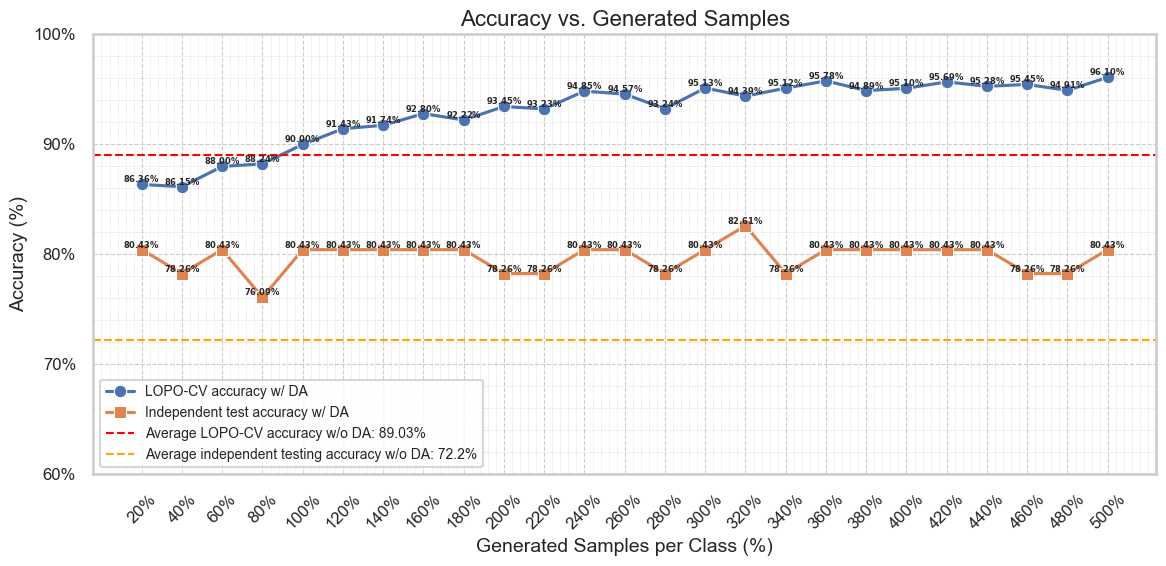

In [20]:
loocv_pct = [s * 100 for s in loocv_scores]
test_pct  = [s * 100 for s in test_scores]

# y low limit
min_val = min(loocv_pct + test_pct)
lower = int(np.floor((min_val - 10) / 10)) * 10
lower = max(lower, 0)

# y top limit
max_val = max(loocv_pct + test_pct)
upper = max_val + 2
upper = min(upper, 102)  


sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 6))



sns.lineplot(
    x=gen_counts, y=loocv_pct, marker="o",
    label="LOPO-CV accuracy w/ DA", ax=ax, clip_on=False,
)
sns.lineplot(
    x=gen_counts, y=test_pct, marker="s",
    label="Independent test accuracy w/ DA", ax=ax, clip_on=False
)



for x, y in zip(gen_counts, loocv_pct):
    ax.text(
        x, y, f"$\\mathbf{{{y:.2f}\\%}}$", va='bottom', ha='center',
        fontsize=6, clip_on=False, 
    )

for x, y in zip(gen_counts, test_pct):
    ax.text(
        x, y, f"$\\mathbf{{{y:.2f}\\%}}$", va='bottom', ha='center',
        fontsize=6, clip_on=False
    )



# baseline
baseline = 89.03
ax.axhline(
    baseline, linestyle='--', label=f'Average LOPO-CV accuracy w/o DA: {baseline}%',
    clip_on=False, color='red', linewidth=1.5
)

baseline_2 = 72.20
ax.axhline(
    baseline_2, linestyle='--', label=f'Average independent testing accuracy w/o DA: {baseline_2}%',
    clip_on=False, color='orange', linewidth=1.5
)

# X axis
ax.set_xticks(gen_counts)
ax.set_xticklabels([f"{x*2}%" for x in gen_counts], rotation=45)

# Y axis
ax.set_ylim(lower, upper)
yticks = list(range(lower, 101, 10))
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y}%" for y in yticks])

ax.tick_params(axis='both', labelsize=12)   
ax.set_xlabel("Generated Samples per Class (%)", fontsize=14)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_title("Accuracy vs. Generated Samples", fontsize=16)
ax.minorticks_on()
ax.grid(which="major", linestyle="--", linewidth=0.8)
ax.grid(which="minor", linestyle=":", linewidth=0.5)
ax.legend(fontsize=10)

plt.tight_layout()
# plt.savefig("../result/MDD_HC/BVAE/B=2/accuracy_vs_generated_samples.png", dpi=300)
plt.show()

In [21]:
average_loocv = np.mean(loocv_scores) * 100
average_test  = np.mean(test_scores) * 100
print(f"Average LOOCV accuracy: {average_loocv:.2f}%")
print(f"Average independent test accuracy: {average_test:.2f}%")

Average LOOCV accuracy: 92.97%
Average independent test accuracy: 79.74%


##### average SWD

Gaussian Noise SWD (averaged over classes): 0.7619
Real Data Split SWD (averaged over classes): 0.0323
Average Generated vs Real SWD: 0.0503
Average Generated vs Shuffled Real SWD: 0.0562


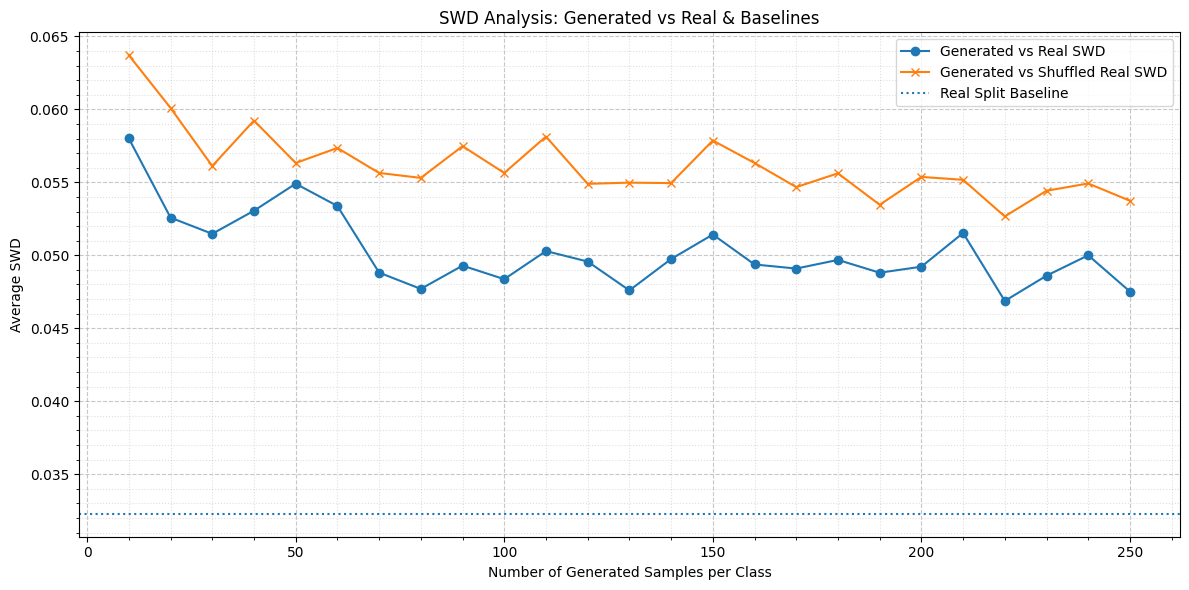

In [18]:
# Reset Seaborn to default settings
sns.reset_defaults()

# Sliced Wasserstein Distance function
def sliced_wasserstein_distance(X, Y, num_projections=100):
    d = X.shape[1]
    swd = 0.0
    for _ in range(num_projections):
        direction = np.random.randn(d)
        direction /= np.linalg.norm(direction)
        projX = X @ direction
        projY = Y @ direction
        m = max(len(projX), len(projY))
        qs = np.linspace(0, 1, m)
        qx = np.quantile(projX, qs)
        qy = np.quantile(projY, qs)
        swd += np.mean(np.abs(qx - qy))
    return swd / num_projections

# Original data by class
orig0 = X_train_final[y_train == 0]
orig1 = X_train_final[y_train == 1]

# 1. Baseline: Gaussian noise vs. real samples
noise0 = np.random.randn(*orig0.shape)
noise1 = np.random.randn(*orig1.shape)
swd_noise0 = sliced_wasserstein_distance(noise0, orig0)
swd_noise1 = sliced_wasserstein_distance(noise1, orig1)
gaussian_swd = (swd_noise0 + swd_noise1) / 2
print(f'Gaussian Noise SWD (averaged over classes): {gaussian_swd:.4f}')

# 2. Baseline: Split real data into halves and compute SWD
def compute_split_swd(data):
    n = len(data)
    idxs = np.random.permutation(n)
    half = n // 2
    part1 = data[idxs[:half]]
    part2 = data[idxs[half:2*half]]
    return sliced_wasserstein_distance(part1, part2)

swd_split0 = compute_split_swd(orig0)
swd_split1 = compute_split_swd(orig1)
split_swd = (swd_split0 + swd_split1) / 2
print(f'Real Data Split SWD (averaged over classes): {split_swd:.4f}')

# 3. Prepare shuffled real data across all classes
shuffled_all = shuffle(X_train_final, random_state=43)
shuffled0 = shuffled_all[:len(orig0)]
shuffled1 = shuffled_all[len(orig0):len(orig0)+len(orig1)]

# 4. SWD for generated vs real & generated vs shuffled real
swd_means = []
swd_shuffled = []

for r in gen_counts:
    synth0 = all_generated[r]['synth0']
    synth1 = all_generated[r]['synth1']
    
    # Generated vs Real
    swd0 = sliced_wasserstein_distance(synth0, orig0)
    swd1 = sliced_wasserstein_distance(synth1, orig1)
    swd_means.append((swd0 + swd1) / 2)
    
    # Generated vs Shuffled Real (across classes)
    swd0_shuf = sliced_wasserstein_distance(synth0, shuffled0)
    swd1_shuf = sliced_wasserstein_distance(synth1, shuffled1)
    swd_shuffled.append((swd0_shuf + swd1_shuf) / 2)

# Print overall average SWD for generated data
overall_avg_swd = np.mean(swd_means)
print(f'Average Generated vs Real SWD: {overall_avg_swd:.4f}')
# Print overall average SWD for generated vs shuffled real data
overall_avg_swd_shuffled = np.mean(swd_shuffled)
print(f'Average Generated vs Shuffled Real SWD: {overall_avg_swd_shuffled:.4f}')

# Plot SWD curves (excluding Gaussian noise baseline if desired)
plt.figure(figsize=(12, 6))
plt.plot(gen_counts, swd_means, marker='o', label='Generated vs Real SWD')
plt.plot(gen_counts, swd_shuffled, marker='x', label='Generated vs Shuffled Real SWD')
plt.axhline(split_swd, linestyle=':', label='Real Split Baseline')
plt.xlabel('Number of Generated Samples per Class')
plt.ylabel('Average SWD')
plt.title('SWD Analysis: Generated vs Real & Baselines')
plt.legend()
plt.grid(which='major', linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()

Real Classes SWD: 0.0590
Gaussian Noise SWD (averaged over classes): 0.7535
Real Data Split SWD (averaged over classes): 0.0295
Average Generated vs Real SWD: 0.0499
Average Generated vs Shuffled Real SWD: 0.0563


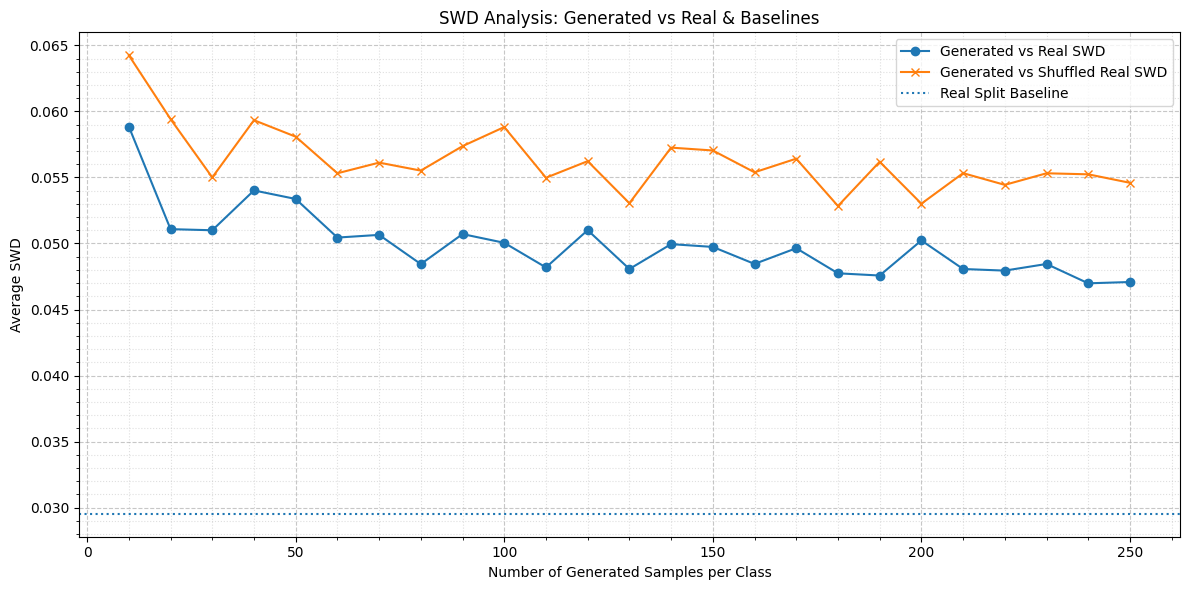

In [19]:

# Reset Seaborn to default settings
sns.reset_defaults()

# Sliced Wasserstein Distance function
def sliced_wasserstein_distance(X, Y, num_projections=100):
    d = X.shape[1]
    swd = 0.0
    for _ in range(num_projections):
        direction = np.random.randn(d)
        direction /= np.linalg.norm(direction)
        projX = X @ direction
        projY = Y @ direction
        m = max(len(projX), len(projY))
        qs = np.linspace(0, 1, m)
        qx = np.quantile(projX, qs)
        qy = np.quantile(projY, qs)
        swd += np.mean(np.abs(qx - qy))
    return swd / num_projections

# Original data by class
orig0 = X_train_final[y_train == 0]
orig1 = X_train_final[y_train == 1]

# Compute SWD between the two real classes
swd_between_real = sliced_wasserstein_distance(orig0, orig1)
print(f'Real Classes SWD: {swd_between_real:.4f}')

# 1. Baseline: Gaussian noise vs. real samples
noise0 = np.random.randn(*orig0.shape)
noise1 = np.random.randn(*orig1.shape)
swd_noise0 = sliced_wasserstein_distance(noise0, orig0)
swd_noise1 = sliced_wasserstein_distance(noise1, orig1)
gaussian_swd = (swd_noise0 + swd_noise1) / 2
print(f'Gaussian Noise SWD (averaged over classes): {gaussian_swd:.4f}')

# 2. Baseline: Split real data into halves and compute SWD
def compute_split_swd(data):
    n = len(data)
    idxs = np.random.permutation(n)
    half = n // 2
    part1 = data[idxs[:half]]
    part2 = data[idxs[half:2*half]]
    return sliced_wasserstein_distance(part1, part2)

swd_split0 = compute_split_swd(orig0)
swd_split1 = compute_split_swd(orig1)
split_swd = (swd_split0 + swd_split1) / 2
print(f'Real Data Split SWD (averaged over classes): {split_swd:.4f}')

# 3. Prepare shuffled real data across all classes
shuffled_all = shuffle(X_train_final, random_state=43)
shuffled0 = shuffled_all[:len(orig0)]
shuffled1 = shuffled_all[len(orig0):len(orig0)+len(orig1)]

# 4. SWD for generated vs real & generated vs shuffled real
swd_means = []
swd_shuffled = []

for r in gen_counts:
    synth0 = all_generated[r]['synth0']
    synth1 = all_generated[r]['synth1']
    
    # Generated vs Real
    swd0 = sliced_wasserstein_distance(synth0, orig0)
    swd1 = sliced_wasserstein_distance(synth1, orig1)
    swd_means.append((swd0 + swd1) / 2)
    
    # Generated vs Shuffled Real (across classes)
    swd0_shuf = sliced_wasserstein_distance(synth0, shuffled0)
    swd1_shuf = sliced_wasserstein_distance(synth1, shuffled1)
    swd_shuffled.append((swd0_shuf + swd1_shuf) / 2)

# Print overall average SWD for generated data
overall_avg_swd = np.mean(swd_means)
print(f'Average Generated vs Real SWD: {overall_avg_swd:.4f}')
# Print overall average SWD for generated vs shuffled real data
overall_avg_swd_shuffled = np.mean(swd_shuffled)
print(f'Average Generated vs Shuffled Real SWD: {overall_avg_swd_shuffled:.4f}')

# Plot SWD curves (excluding Gaussian noise baseline if desired)
plt.figure(figsize=(12, 6))
plt.plot(gen_counts, swd_means, marker='o', label='Generated vs Real SWD')
plt.plot(gen_counts, swd_shuffled, marker='x', label='Generated vs Shuffled Real SWD')
plt.axhline(split_swd, linestyle=':', label='Real Split Baseline')
plt.xlabel('Number of Generated Samples per Class')
plt.ylabel('Average SWD')
plt.title('SWD Analysis: Generated vs Real & Baselines')
plt.legend()
plt.grid(which='major', linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()


##### load result

In [14]:
with open('../result/MDD_HC/BVAE/B=2(select)/all_generated_samples.pkl', 'rb') as f:
    all_generated = pickle.load(f)


with open('../result/MDD_HC/BVAE/B=2(select)/svm_loocv_test_history.pkl', 'rb') as f:
    history = pickle.load(f)

In [15]:
gen_counts = history['gen_counts']
loocv_scores = history['loocv_scores']
test_scores = history['test_scores']
best_params_all = history['best_params']

In [16]:
vae = cVAE(input_dim=dummy_input_dim, latent_dim=latent_dim_pt, num_classes=num_classes)
checkpoint = torch.load(
    "../result/MDD_HC/BVAE/B=2(select)/vae_model.pt",
    map_location=torch.device('cpu')
)
vae.load_state_dict(checkpoint)
vae.eval()

C:\Users\NESS-Kuan\AppData\Local\Temp\ipykernel_12888\454952869.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


cVAE(
  (conv1d_enc): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_enc): Sequential(
    (0): Linear(in_features=6402, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_mu): Linear(in_features=32, out_features=15, bias=True)
  (fc_logvar): Linear(in_features=32, out_feature

##### plot t-SNE & confusion matrix

In [22]:
sns.reset_defaults()
cv_loocv = LeaveOneOut()

def plot_combined_confusion(r, params, filename=None):

    synth0 = all_generated[r]['synth0']
    synth1 = all_generated[r]['synth1']

    # augment train set
    X_aug = np.vstack([X_train_final, synth0, synth1])
    y_aug = np.concatenate([y_train, np.zeros(r), np.ones(r)])


    y_pred_loocv = cross_val_predict(
        SVC(**params), X_aug, y_aug, cv=cv_loocv, n_jobs=-1
    )
    cm_loocv = confusion_matrix(y_aug, y_pred_loocv)

    clf = SVC(**params)
    clf.fit(X_aug, y_aug)
    y_pred_test = clf.predict(X_test_final)
    cm_test = confusion_matrix(y_test, y_pred_test)


    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ---- LOPO-CV ----
    disp1 = ConfusionMatrixDisplay(
        cm_loocv,
        display_labels=["HC", "MDD"]
    )
    disp1.plot(
        ax=axes[0],
        cmap=plt.cm.Blues,
        colorbar=False,
        text_kw={'fontsize': 14}       # enlarge cell text
    )
    axes[0].set_title(
        f"LOPO-CV confusion matrix\n(generated data per class={r*2}%)",
        fontsize=16,                   # enlarge title
        pad=12
    )
    axes[0].tick_params(axis='both', labelsize=14)  # enlarge tick labels
    axes[0].set_xlabel(axes[0].get_xlabel(), fontsize=14)
    axes[0].set_ylabel(axes[0].get_ylabel(), fontsize=14)

    # ---- Independent Test ----
    disp2 = ConfusionMatrixDisplay(
        cm_test,
        display_labels=["HC", "MDD"]
    )
    disp2.plot(
        ax=axes[1],
        cmap=plt.cm.Blues,
        colorbar=False,
        text_kw={'fontsize': 14}
    )
    axes[1].set_title(
        f"Independent test confusion matrix\n(generated data per class={r*2}%)",
        fontsize=16,
        pad=12
    )
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].set_xlabel(axes[1].get_xlabel(), fontsize=14)
    axes[1].set_ylabel(axes[1].get_ylabel(), fontsize=14)

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=300)
    plt.show()





def plot_tsne(r, params, filename=None):
    synth0 = all_generated[r]['synth0']
    synth1 = all_generated[r]['synth1']

    
    X_vis = np.vstack([X_train_final, synth0, synth1, X_test_final])
    y_vis = np.concatenate([y_train, np.zeros(r), np.ones(r), y_test])
    types = (
        ['train'] * len(X_train_final) +
        ['gen']  * (2 * r) +
        ['test'] * len(X_test_final)
    )


    emb = TSNE(n_components=2, random_state=43)
    emb_results = emb.fit_transform(X_vis)

 
    color_map = {
        (0, 'train'): 'tab:blue',   (0, 'gen'): 'skyblue',   (0, 'test'): 'navy',
        (1, 'train'): 'tab:orange', (1, 'gen'): 'lightsalmon', (1, 'test'): 'darkorange'
    }
    marker_map = {'train': 'o', 'gen': '^', 'test': 'x'}


    fig, ax = plt.subplots(figsize=(8, 6))
    for cls in [0, 1]:
        for t in ['train', 'gen', 'test']:
            idx = np.where((y_vis == cls) & (np.array(types) == t))
            ax.scatter(
                emb_results[idx, 0], emb_results[idx, 1],
                label=f"{['HC','MDD'][cls]}-{t}",
                marker=marker_map[t],
                color=color_map[(cls, t)],
                alpha=0.7
            )

    ax.legend(fontsize=8, markerscale=0.8)
    ax.set_title(f"t-SNE (generated data per class={r*2}%)")
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=300)
    plt.show()

In [23]:
best_loocv_r = gen_counts[np.argmax(loocv_scores)]
best_loocv_p = best_params_all[np.argmax(loocv_scores)]
best_test_r  = gen_counts[np.argmax(test_scores)]
best_test_p  = best_params_all[np.argmax(test_scores)]

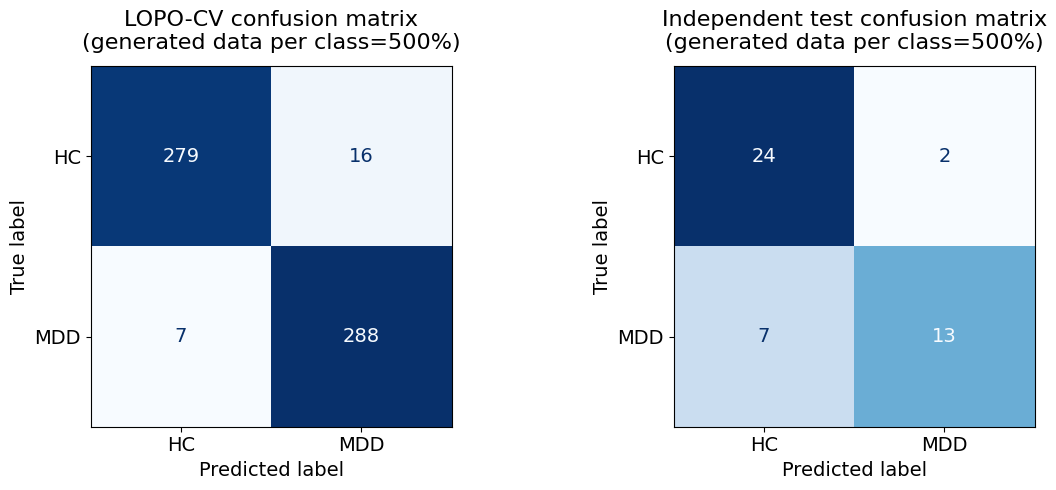

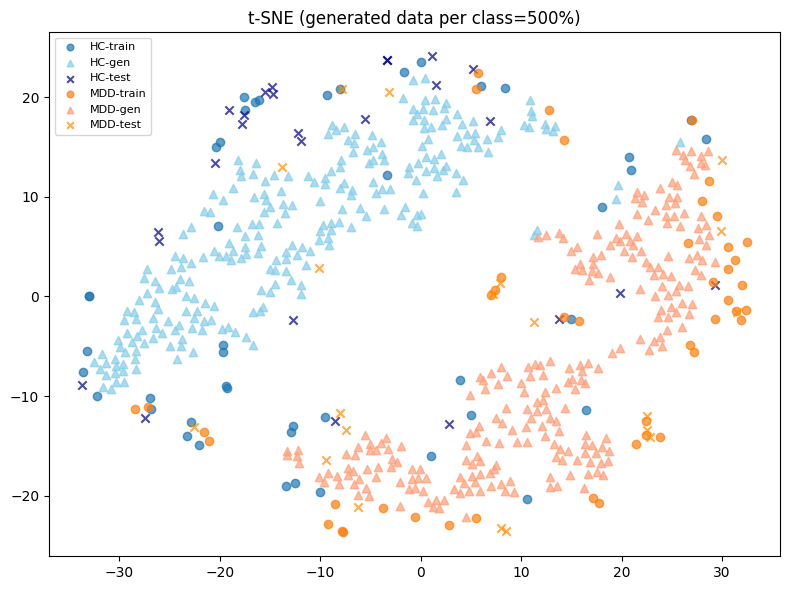

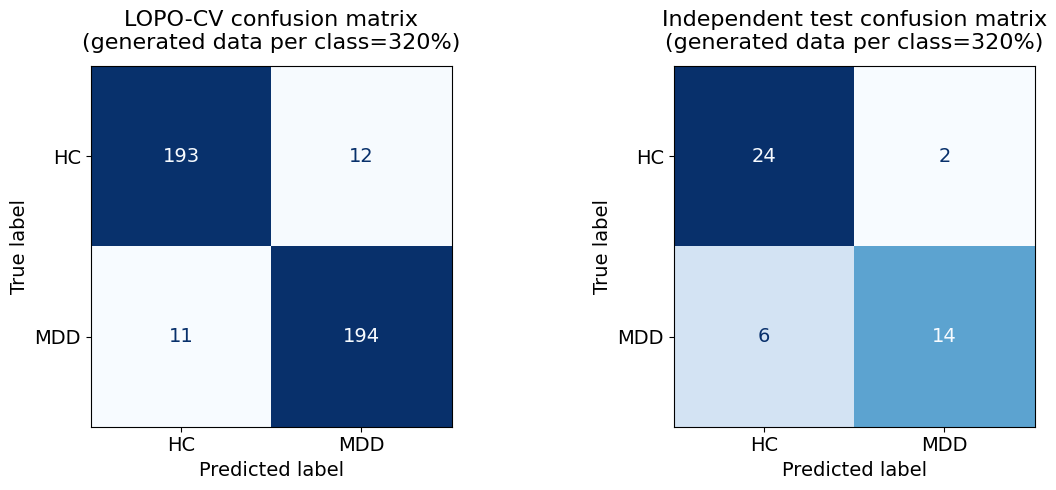

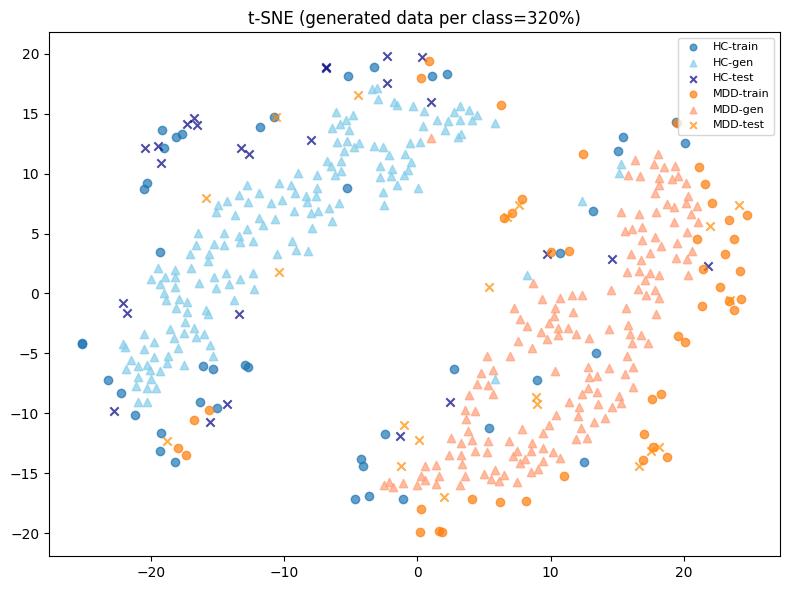

In [24]:
plot_combined_confusion(
    best_loocv_r, best_loocv_p,
)
plot_tsne(
    best_loocv_r, best_loocv_p,
)


plot_combined_confusion(
    best_test_r, best_test_p,
)
plot_tsne(
    best_test_r, best_test_p,
)

##### save t-SNE & confusion matrix

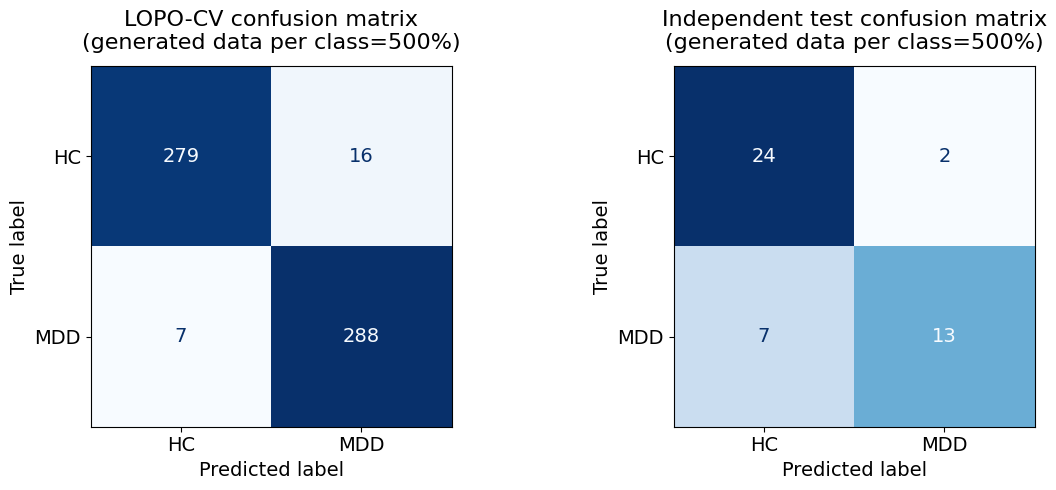

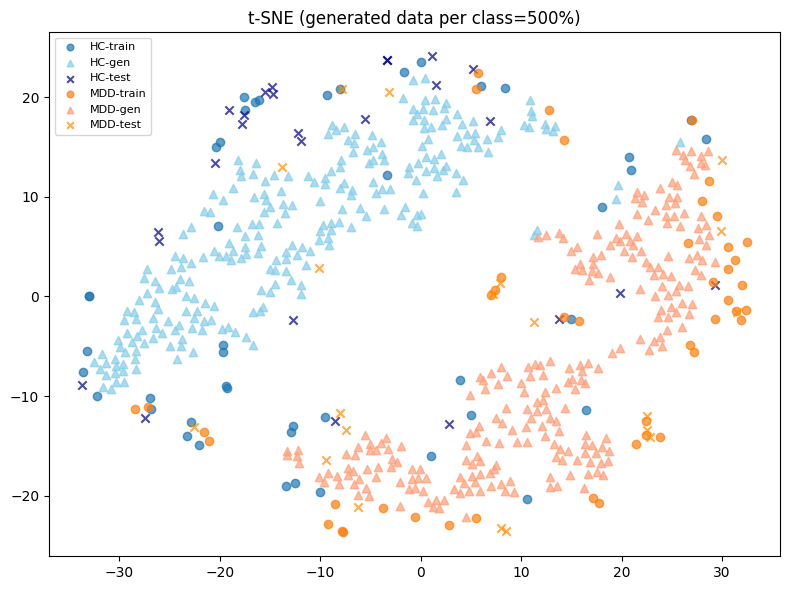

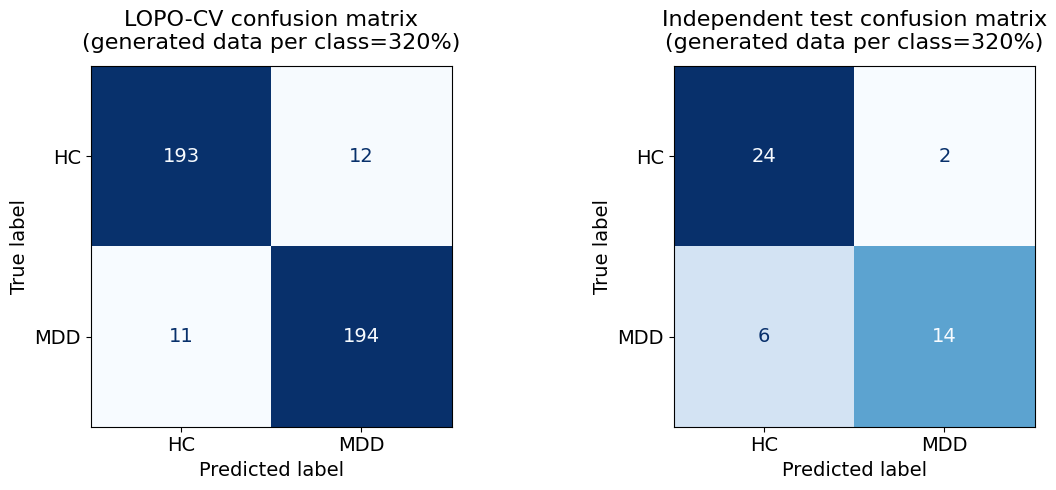

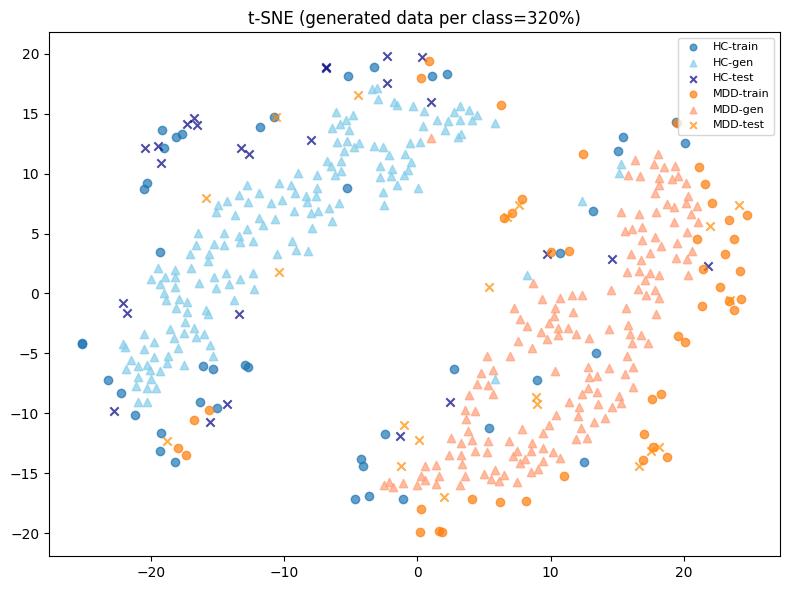

In [25]:
plot_combined_confusion(
    best_loocv_r, best_loocv_p,
    f"../result/MDD_HC/BVAE/B=2(select)/cm_combined_loocv_r{best_loocv_r}.png"
)
plot_tsne(
    best_loocv_r, best_loocv_p,
    f"../result/MDD_HC/BVAE/B=2(select)/tsne_loocv_r{best_loocv_r}.png"
)


plot_combined_confusion(
    best_test_r, best_test_p,
    f"../result/MDD_HC/BVAE/B=2(select)/cm_combined_test_r{best_test_r}.png"
)
plot_tsne(
    best_test_r, best_test_p,
    f"../result/MDD_HC/BVAE/B=2(select)/tsne_test_r{best_test_r}.png")

##### save model

In [68]:
model = vae.state_dict()
with open("../result/MDD_HC/BVAE/B=2/vae_model.pt", "wb") as f:
    torch.save(model, f)

##### save result

In [15]:
import pickle


results = {

    "cvae_state_dict": cvae_merged.state_dict(),
    

    "X_train_final": X_train_final,      
    "y_train": y_train,
    "X_test_final": X_test_final,
    "y_test": y_test,
    

    "X_train_aug": X_train_aug,
    "y_train_aug": y_train_aug,
    

    "X_tsne_original": X_tsne_original,
    "X_tsne_aug": X_tsne_aug,
    

    "new_best_params": new_best_params,
    

    "clf_original": clf_original,
    "clf_aug_new": clf_aug_new
}


with open("../result/BD_MDD/info_cvae/results_test.pkl", "wb") as f:
    pickle.dump(results, f)

##### DA size analyze

In [18]:
latent_dim_pt = 15
model = cVAE(input_dim=X_train_final.shape[1], latent_dim=latent_dim_pt, num_classes=2)
with open("../result/BD_MDD/info_cvae/results_test.pkl", "rb") as f:
    results = pickle.load(f)
model.load_state_dict(results["cvae_state_dict"])
model.eval()

cVAE(
  (conv1d_enc): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_enc): Sequential(
    (0): Linear(in_features=2114, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_mu): Linear(in_features=32, out_features=15, bias=True)
  (fc_logvar): Linear(in_features=32, out_feature

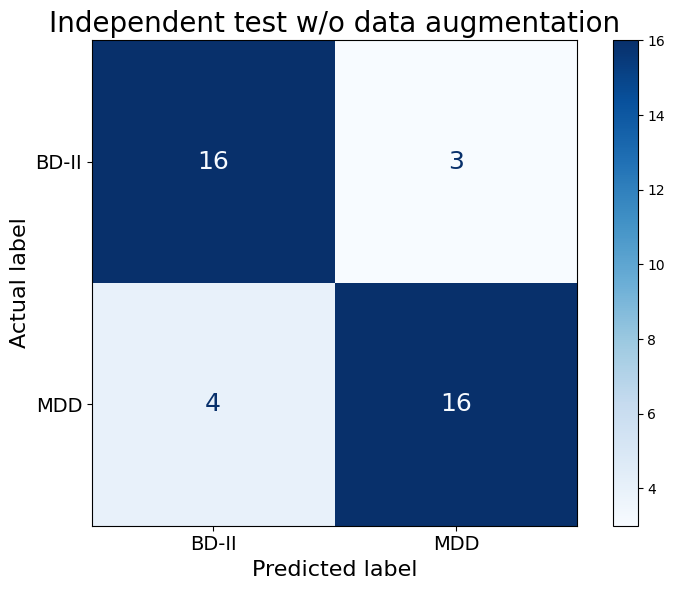

In [19]:
clf_orig = SVC(**best_overall["best_params"])
clf_orig.fit(X_train_final, y_train)
y_pred_orig = clf_orig.predict(X_test_final)
cm_orig = confusion_matrix(y_test, y_pred_orig)
fig1, ax1 = plt.subplots(figsize=(8,6))
disp1 = ConfusionMatrixDisplay(
    cm_orig,
    display_labels=["BD-II", "MDD"]
).plot(
    ax=ax1,
    cmap=plt.cm.Blues,
    text_kw={'fontsize':18}
)
ax1.set_title("Independent test w/o data augmentation", fontsize=20)
ax1.set_xlabel("Predicted label", fontsize=16)
ax1.set_ylabel("Actual label", fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/confusion_before_augmentation.png")

In [89]:
augmentation_counts = list(range(50, 501, 10))
accuracies = []
synthetic_data = {}
for r in augmentation_counts:
    cond0 = torch.zeros(r, 2); cond0[:,0] = 1
    cond1 = torch.zeros(r, 2); cond1[:,1] = 1
    synth0 = model.decode(torch.randn(r, latent_dim_pt), cond0).detach().cpu().numpy()
    synth1 = model.decode(torch.randn(r, latent_dim_pt), cond1).detach().cpu().numpy()
    synthetic_data[r] = {'class0': synth0, 'class1': synth1}

    X_aug = np.vstack([X_train_final, synth0, synth1])
    y_aug = np.concatenate([y_train, np.zeros(r), np.ones(r)])
    clf = SVC(**best_overall["best_params"])
    clf.fit(X_aug, y_aug)
    acc = accuracy_score(y_test, clf.predict(X_test_final))
    accuracies.append(acc)
    print(f"Augmentation per class = {r}: Test Accuracy = {acc*100:.2f}%")

Augmentation per class = 50: Test Accuracy = 82.05%
Augmentation per class = 60: Test Accuracy = 87.18%
Augmentation per class = 70: Test Accuracy = 84.62%
Augmentation per class = 80: Test Accuracy = 84.62%
Augmentation per class = 90: Test Accuracy = 84.62%
Augmentation per class = 100: Test Accuracy = 82.05%
Augmentation per class = 110: Test Accuracy = 84.62%
Augmentation per class = 120: Test Accuracy = 84.62%
Augmentation per class = 130: Test Accuracy = 84.62%
Augmentation per class = 140: Test Accuracy = 84.62%
Augmentation per class = 150: Test Accuracy = 84.62%
Augmentation per class = 160: Test Accuracy = 84.62%
Augmentation per class = 170: Test Accuracy = 84.62%
Augmentation per class = 180: Test Accuracy = 84.62%
Augmentation per class = 190: Test Accuracy = 84.62%
Augmentation per class = 200: Test Accuracy = 84.62%
Augmentation per class = 210: Test Accuracy = 87.18%
Augmentation per class = 220: Test Accuracy = 84.62%
Augmentation per class = 230: Test Accuracy = 84.62

In [ ]:
param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1.05**exp for exp in range(-100, 101, 10)]
    },
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100, 1000]
    }
]


loo = LeaveOneOut()

augmentation_counts = list(range(50, 501, 10))
accuracies = []
synthetic_data = {}

for r in augmentation_counts:
    cond0 = torch.zeros(r, 2); cond0[:,0] = 1
    cond1 = torch.zeros(r, 2); cond1[:,1] = 1
    synth0 = model.decode(torch.randn(r, latent_dim_pt), cond0).detach().cpu().numpy()
    synth1 = model.decode(torch.randn(r, latent_dim_pt), cond1).detach().cpu().numpy()
    synthetic_data[r] = {'class0': synth0, 'class1': synth1}

    X_aug = np.vstack([X_train_final, synth0, synth1])
    y_aug = np.concatenate([y_train, np.zeros(r), np.ones(r)])


    grid = GridSearchCV(
        estimator=SVC(),
        param_grid=param_grid,
        cv=loo,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_aug, y_aug)
    best_params = grid.best_params_


    clf = SVC(**best_params)
    clf.fit(X_aug, y_aug)
    acc = accuracy_score(y_test, clf.predict(X_test_final))
    accuracies.append(acc)

    print(f"r = {r:3d} │ Best Params: {best_params} │ Test Accuracy = {acc*100:.2f}%")

r =  50 │ Best Params: {'C': 1000, 'gamma': 0.053535523746494146, 'kernel': 'rbf'} │ Test Accuracy = 76.92%
r =  60 │ Best Params: {'C': 1000, 'gamma': 0.053535523746494146, 'kernel': 'rbf'} │ Test Accuracy = 79.49%
r =  70 │ Best Params: {'C': 1000, 'gamma': 0.053535523746494146, 'kernel': 'rbf'} │ Test Accuracy = 82.05%
r =  80 │ Best Params: {'C': 1000, 'gamma': 0.14204568230027764, 'kernel': 'rbf'} │ Test Accuracy = 82.05%
r =  90 │ Best Params: {'C': 1000, 'gamma': 0.053535523746494146, 'kernel': 'rbf'} │ Test Accuracy = 79.49%
r = 100 │ Best Params: {'C': 100, 'gamma': 0.6139132535407591, 'kernel': 'rbf'} │ Test Accuracy = 76.92%
r = 110 │ Best Params: {'C': 1000, 'gamma': 0.03286616756321879, 'kernel': 'rbf'} │ Test Accuracy = 76.92%
r = 120 │ Best Params: {'C': 100, 'gamma': 0.6139132535407591, 'kernel': 'rbf'} │ Test Accuracy = 76.92%
r = 130 │ Best Params: {'C': 100, 'gamma': 1.0, 'kernel': 'rbf'} │ Test Accuracy = 76.92%
r = 140 │ Best Params: {'C': 100, 'gamma': 0.376889482

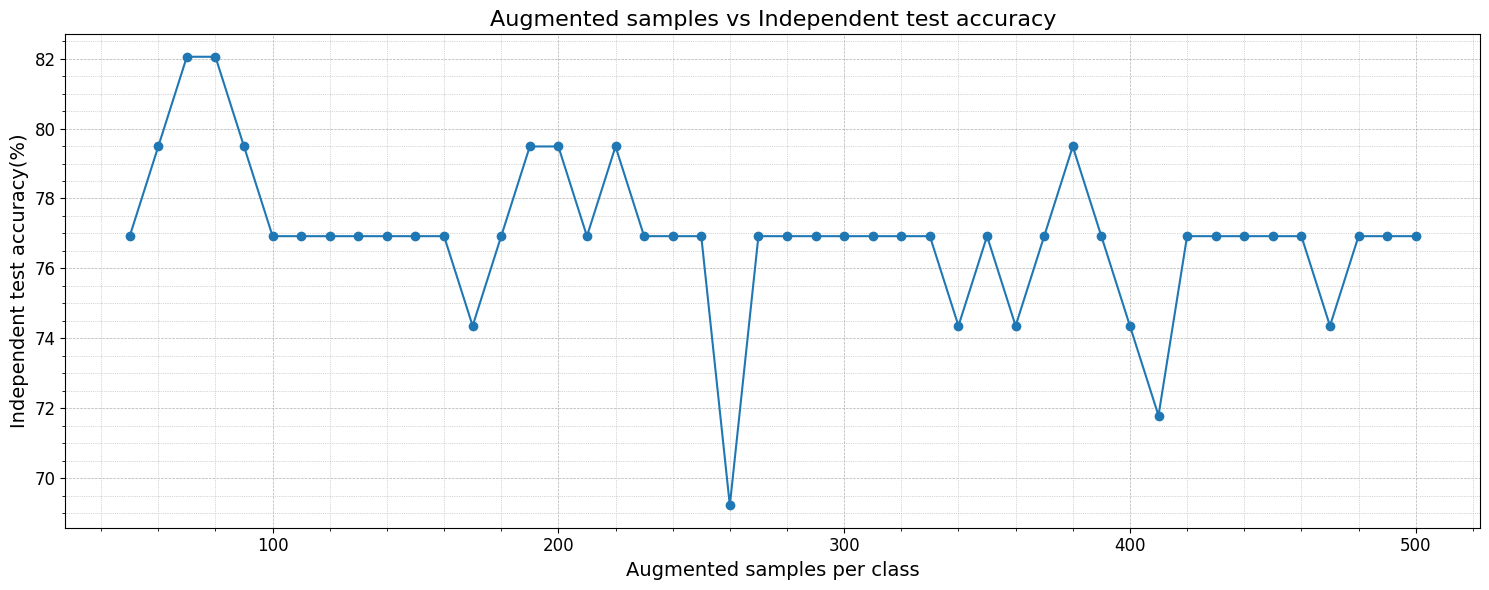

In [21]:
fig2, ax2 = plt.subplots(figsize=(15,6))
ax2.plot(augmentation_counts, [a*100 for a in accuracies], marker='o')
ax2.set_xlabel("Augmented samples per class", fontsize=14)
ax2.set_ylabel("Independent test accuracy(%)", fontsize=14)
ax2.set_title("Augmented samples vs Independent test accuracy", fontsize=16)
ax2.minorticks_on()
ax2.grid(True, which='major', linestyle='--', linewidth=0.5)
ax2.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax2.tick_params(axis='both', labelsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/accuracy_vs_augmentation_num.png")

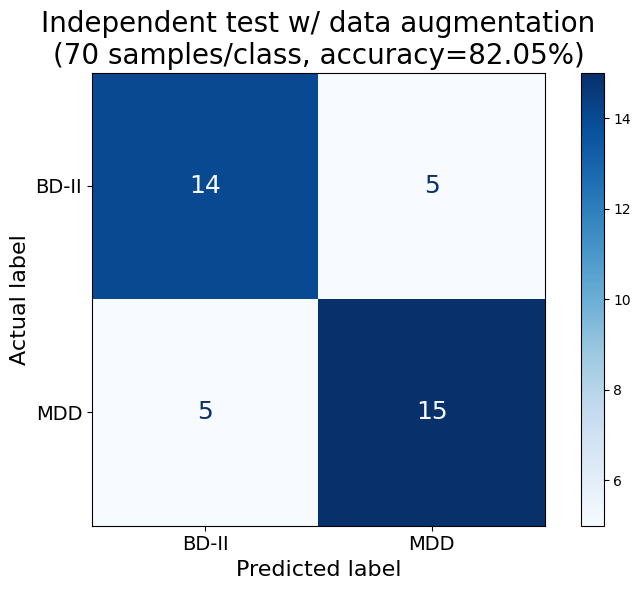

In [22]:
max_acc = max(accuracies)
best_indices = [i for i, a in enumerate(accuracies) if a == max_acc]
best_idx = best_indices[0]
r_best = augmentation_counts[best_idx]
acc_best = accuracies[best_idx] * 100

s0 = synthetic_data[r_best]['class0']
s1 = synthetic_data[r_best]['class1']
clf_best = SVC(**best_overall["best_params"])
clf_best.fit(
    np.vstack([X_train_final, s0, s1]),
    np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
)
cm_best = confusion_matrix(y_test, clf_best.predict(X_test_final))
fig3, ax3 = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay(
    cm_best,
    display_labels=["BD-II", "MDD"]
).plot(
    ax=ax3,
    cmap=plt.cm.Blues,
    text_kw={'fontsize':18}
)
ax3.set_title(
    f"Independent test w/ data augmentation\n({r_best} samples/class, accuracy={acc_best:.2f}%)",
    fontsize=20
)
ax3.set_xlabel("Predicted label", fontsize=16)
ax3.set_ylabel("Actual label", fontsize=16)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/confusion_after_augmentation.png")


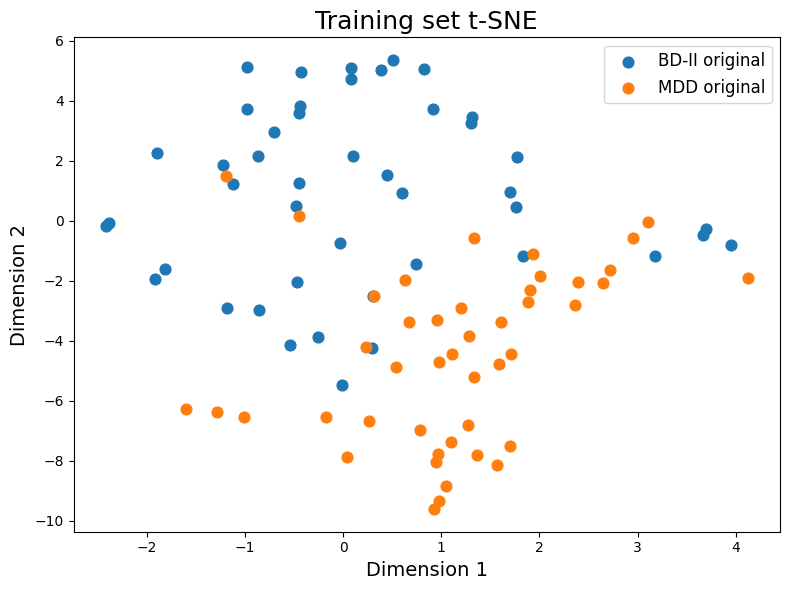

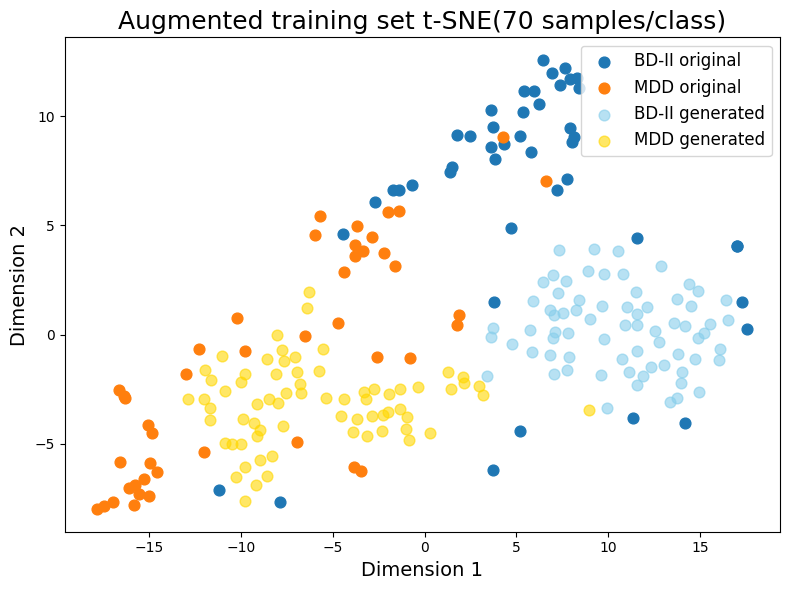

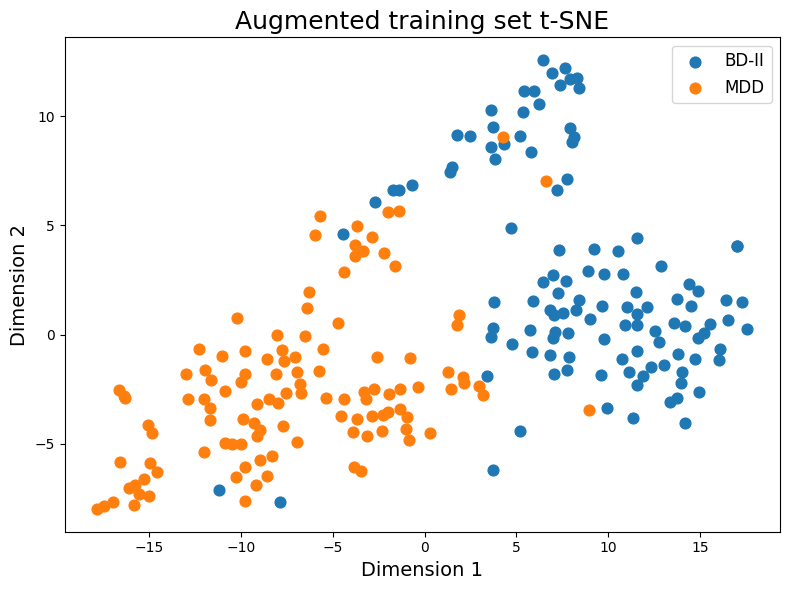

In [23]:
from sklearn.manifold import TSNE

# t-SNE before augmentation (original training set)
tsne = TSNE(n_components=2, random_state=42)
X_tsne_before = tsne.fit_transform(X_train_final)
fig_tsne1, ax_tsne1 = plt.subplots(figsize=(8,6))

colors = {'BD_orig':'tab:blue', 'BD_syn':'skyblue', 'MDD_orig':'tab:orange', 'MDD_syn':'gold'}
for label, marker, label_name, key in zip(
    [0,1], ['o','o'], ['BD-II original','MDD original'], ['BD_orig','MDD_orig']):
    idx = (y_train == label)
    ax_tsne1.scatter(
        X_tsne_before[idx,0], X_tsne_before[idx,1],
        label=label_name, marker=marker, s=60, color=colors[key]
    )
ax_tsne1.set_title("Training set t-SNE", fontsize=18)
ax_tsne1.set_xlabel("Dimension 1", fontsize=14)
ax_tsne1.set_ylabel("Dimension 2", fontsize=14)
ax_tsne1.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/tsne_before_augmentation.png")




# t-SNE after augmentation (best augmentation training set)
X_aug_best = np.vstack([X_train_final, s0, s1])
y_aug_best = np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
X_tsne_after = tsne.fit_transform(X_aug_best)
fig_tsne2, ax_tsne2 = plt.subplots(figsize=(8,6))

N_orig = len(y_train)
for label, marker, label_name, key in zip(
    [0,1], ['o','o'], ['BD-II original','MDD original'], ['BD_orig','MDD_orig']):
    orig_idx = (y_aug_best[:N_orig] == label)
    pts = X_tsne_after[:N_orig][orig_idx]
    ax_tsne2.scatter(
        pts[:,0], pts[:,1], label=label_name, marker=marker, s=60, color=colors[key]
    )

offset = N_orig
for label, marker, label_name, key in zip(
    [0,1], ['o','o'], ['BD-II generated','MDD generated'], ['BD_syn','MDD_syn']):
    syn_idx = (y_aug_best[offset:] == label)
    pts_syn = X_tsne_after[offset:][syn_idx]
    ax_tsne2.scatter(
        pts_syn[:,0], pts_syn[:,1], label=label_name, marker=marker, s=60,
        alpha=0.6, color=colors[key]
    )
ax_tsne2.set_title(f"Augmented training set t-SNE({r_best} samples/class)", fontsize=18)
ax_tsne2.set_xlabel("Dimension 1", fontsize=14)
ax_tsne2.set_ylabel("Dimension 2", fontsize=14)
ax_tsne2.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/tsne_after_augmentation.png")


tsns = TSNE(n_components=2, random_state=42)
X_combined = np.vstack([X_train_final, s0, s1])
y_combined = np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
X_tsne_comb = tsns.fit_transform(X_combined)
fig_tsne3, ax_tsne3 = plt.subplots(figsize=(8,6))
for label, marker, label_name, color in zip(
    [0,1], ['o','o'], ['BD-II','MDD'], ['tab:blue','tab:orange']):
    idx = (y_combined == label)
    ax_tsne3.scatter(
        X_tsne_comb[idx,0], X_tsne_comb[idx,1],
        label=label_name, marker=marker, s=60, color=color
    )
ax_tsne3.set_title("Augmented training set t-SNE", fontsize=18)
ax_tsne3.set_xlabel("Dimension 1", fontsize=14)
ax_tsne3.set_ylabel("Dimension 2", fontsize=14)
ax_tsne3.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/tsne_combined_augmentation.png")

In [24]:
with open("../result/BD_MDD/DA_num/synthetic_data_test.pkl", "wb") as f:
    pickle.dump(synthetic_data, f)
with open("../result/BD_MDD/DA_num/accuracy_curve_test.pkl", "wb") as f:
    pickle.dump({'counts': augmentation_counts, 'accuracies': accuracies}, f)

print(f"Saved confusion matrix for best augmentation at {r_best} samples/class with accuracy {acc_best:.2f}%.")


Saved confusion matrix for best augmentation at 70 samples/class with accuracy 82.05%.


##### review result

In [12]:
latent_dim_pt = 15
model = cVAE(input_dim=X_train_final.shape[1], latent_dim=latent_dim_pt, num_classes=2)
with open("../result/BD_MDD/info_cvae/results.pkl", "rb") as f:
    results = pickle.load(f)
model.load_state_dict(results["cvae_state_dict"])
model.eval()

cVAE(
  (conv1d_enc): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_enc): Sequential(
    (0): Linear(in_features=2114, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_mu): Linear(in_features=32, out_features=15, bias=True)
  (fc_logvar): Linear(in_features=32, out_feature

In [13]:
with open("../result/BD_MDD/DA_num/synthetic_data.pkl", "rb") as f:
    synthetic_data = pickle.load(f)
with open("../result/BD_MDD/DA_num/accuracy_curve.pkl", "rb") as f:
    acc_dict = pickle.load(f)
augmentation_counts = acc_dict['counts']
accuracies = acc_dict['accuracies']

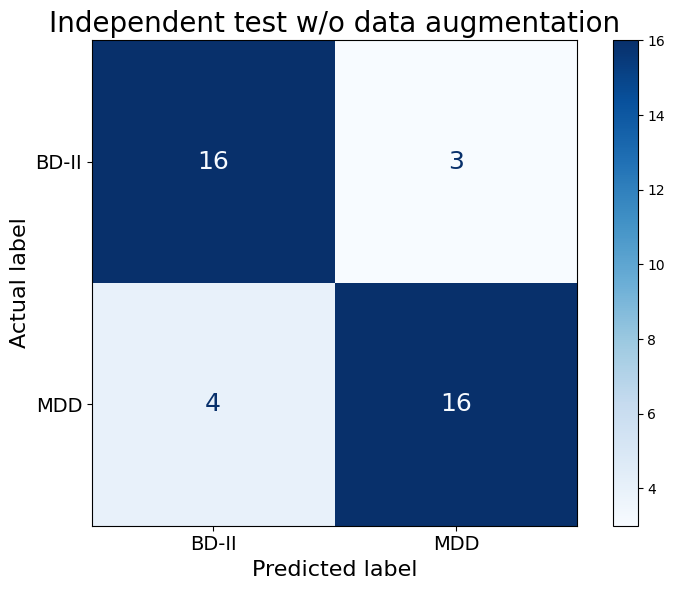

In [14]:
clf_orig = SVC(**best_overall["best_params"])
clf_orig.fit(X_train_final, y_train)
y_pred_orig = clf_orig.predict(X_test_final)
cm_orig = confusion_matrix(y_test, y_pred_orig)
fig1, ax1 = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay(
    cm_orig,
    display_labels=["BD-II", "MDD"],
).plot(
    ax=ax1, cmap=plt.cm.Blues, text_kw={'fontsize':18}
)
ax1.set_title("Independent test w/o data augmentation", fontsize=20)
ax1.set_xlabel("Predicted label", fontsize=16)
ax1.set_ylabel("Actual label", fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
plt.tight_layout()
# plt.savefig("confusion_before_augmentation.png")

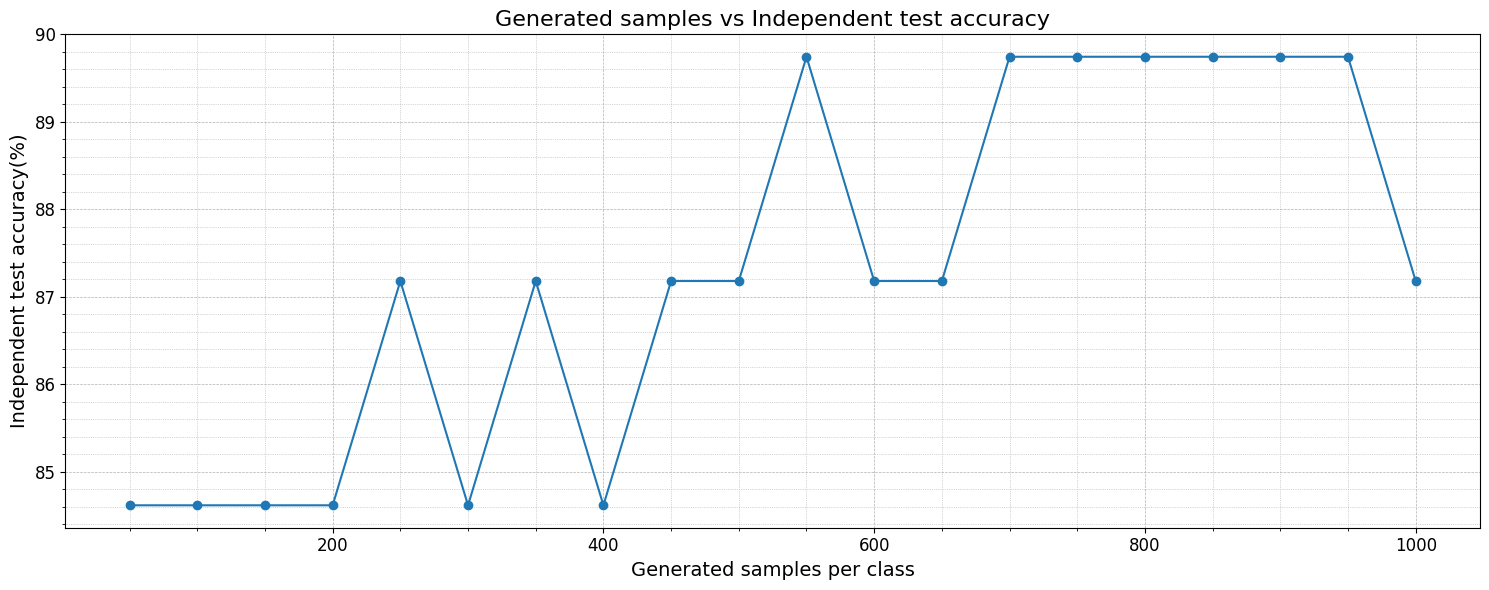

In [15]:
fig2, ax2 = plt.subplots(figsize=(15,6))
ax2.plot(augmentation_counts, [a*100 for a in accuracies], marker='o')
ax2.set_xlabel("Generated samples per class", fontsize=14)
ax2.set_ylabel("Independent test accuracy(%)", fontsize=14)
ax2.set_title("Generated samples vs Independent test accuracy", fontsize=16)
ax2.minorticks_on()
ax2.grid(True, which='major', linestyle='--', linewidth=0.5)
ax2.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax2.tick_params(axis='both', labelsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/accuracy_vs_augmentation.png")

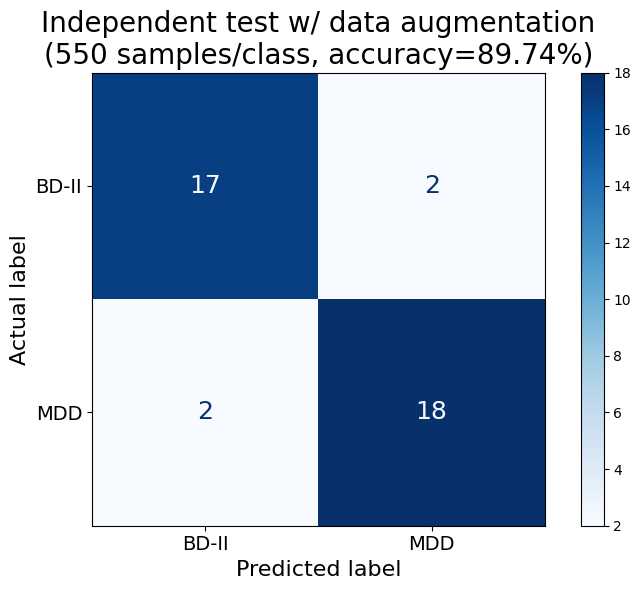

In [16]:
max_acc = max(accuracies)
best_indices = [i for i, a in enumerate(accuracies) if a == max_acc]
best_idx = best_indices[0]
r_best = augmentation_counts[best_idx]
acc_best = accuracies[best_idx] * 100

# ----- Confusion Matrix After Augmentation -----
s0 = synthetic_data[r_best]['class0']
s1 = synthetic_data[r_best]['class1']
clf_best = SVC(**best_overall["best_params"])
clf_best.fit(
    np.vstack([X_train_final, s0, s1]),
    np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
)
cm_best = confusion_matrix(y_test, clf_best.predict(X_test_final))
fig3, ax3 = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay(
    cm_best,
    display_labels=["BD-II", "MDD"],
).plot(
    ax=ax3, cmap=plt.cm.Blues, text_kw={'fontsize':18}
)
ax3.set_title(
    f"Independent test w/ data augmentation\n({r_best} samples/class, accuracy={acc_best:.2f}%)", fontsize=20
)
ax3.set_xlabel("Predicted label", fontsize=16)
ax3.set_ylabel("Actual label", fontsize=16)
ax3.tick_params(axis='both', labelsize=14)
plt.tight_layout()
# plt.savefig("confusion_after_augmentation.png")

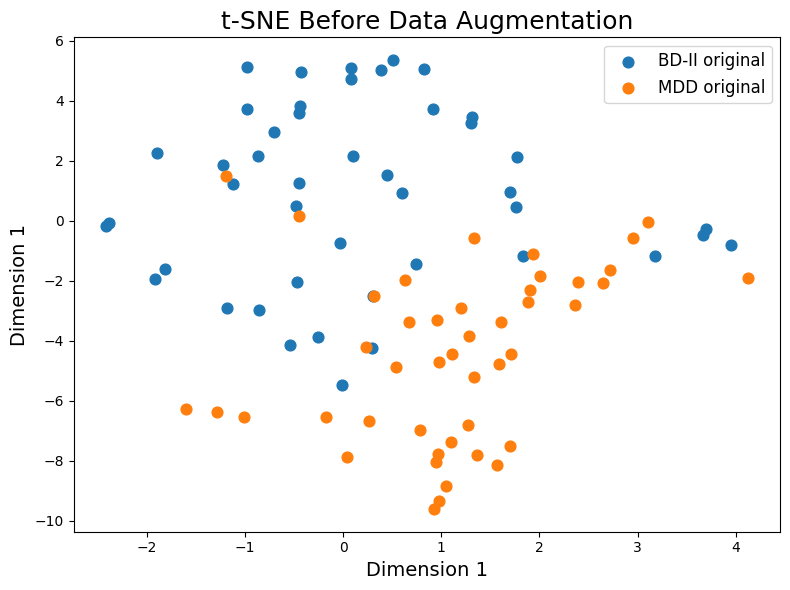

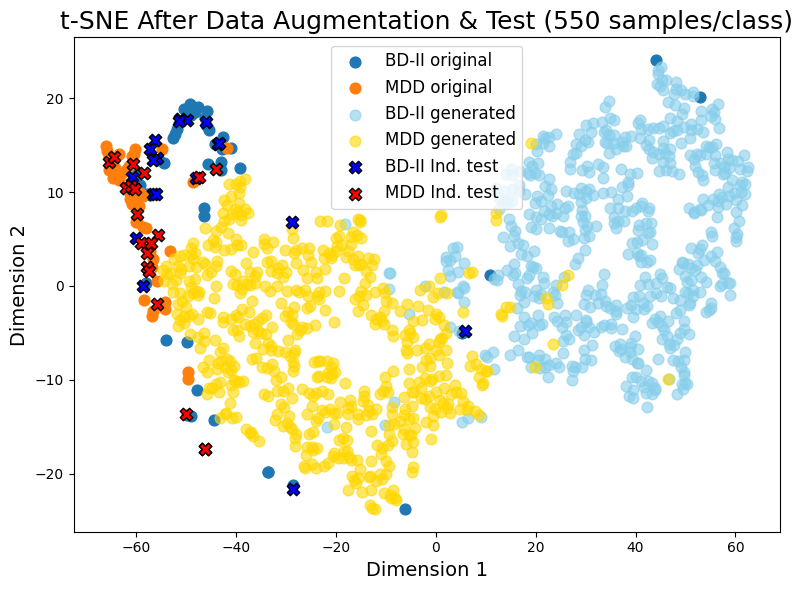

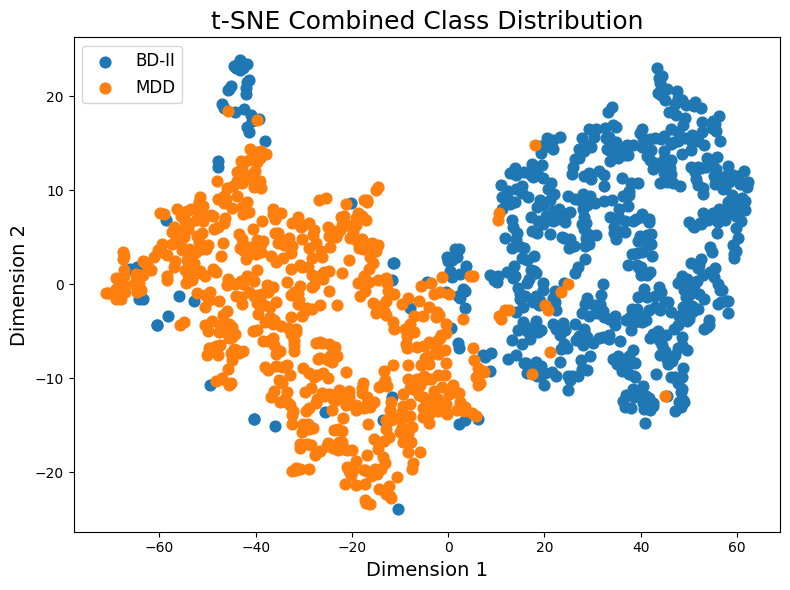

In [17]:
# ----- t-SNE Before Augmentation -----
tsne = TSNE(n_components=2, random_state=42)
X_tsne_before = tsne.fit_transform(X_train_final)
fig_tsne1, ax_tsne1 = plt.subplots(figsize=(8,6))
colors = {'BD_orig':'tab:blue', 'MDD_orig':'tab:orange'}
for label, marker, label_name, key in zip(
    [0,1], ['o','o'], ['BD-II original','MDD original'], ['BD_orig','MDD_orig']):
    idx = (y_train == label)
    ax_tsne1.scatter(X_tsne_before[idx,0], X_tsne_before[idx,1],
                     label=label_name, marker=marker, s=60, color=colors[key])
ax_tsne1.set_title("t-SNE Before Data Augmentation", fontsize=18)
ax_tsne1.set_xlabel("Dimension 1", fontsize=14)
ax_tsne1.set_ylabel("Dimension 1", fontsize=14)
ax_tsne1.legend(fontsize=12)
plt.tight_layout()

# ----- t-SNE After Augmentation -----

X_aug_best = np.vstack([X_train_final, s0, s1])
y_aug_best = np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
X_tsne_input = np.vstack([X_aug_best, X_test_final])
y_tsne_input = np.concatenate([y_aug_best, y_test])


Tsne2 = TSNE(n_components=2, random_state=42)
X_tsne2 = Tsne2.fit_transform(X_tsne_input)


fig_tsne2, ax_tsne2 = plt.subplots(figsize=(8,6))
colors_train = {'BD_orig':'tab:blue', 'BD_syn':'skyblue', 'MDD_orig':'tab:orange', 'MDD_syn':'gold'}

n_train = len(y_train)
n_syn = 2 * r_best


start, end = 0, n_train
for label, marker, key, label_name in zip([
    0, 1
], ['o','o'], ['BD_orig','MDD_orig'], ['BD-II original','MDD original']):
    idx = (y_train == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker=marker, s=60, color=colors_train[key])


start, end = n_train, n_train + n_syn
for label, marker, key, label_name in zip([
    0, 1
], ['o','o'], ['BD_syn','MDD_syn'], ['BD-II generated','MDD generated']):
    syn_labels = y_aug_best[start:end]
    idx = (syn_labels == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker=marker, s=60, color=colors_train[key], alpha=0.6)


start, end = n_train + n_syn, n_train + n_syn + len(y_test)
for label, color, label_name in zip([0,1], ['blue','red'], ['BD-II Ind. test','MDD Ind. test']):
    test_labels = y_tsne_input[start:end]
    idx = (test_labels == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker='X', s=80, edgecolor='k', facecolor=color)

ax_tsne2.set_title(f"t-SNE After Data Augmentation & Test ({r_best} samples/class)", fontsize=18)
ax_tsne2.set_xlabel("Dimension 1", fontsize=14)
ax_tsne2.set_ylabel("Dimension 2", fontsize=14)
ax_tsne2.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/tsne_after_with_train_test.png")



# ----- t-SNE Combined Class Distribution -----
tsns = TSNE(n_components=2, random_state=42)
X_combined = np.vstack([X_train_final, s0, s1])
y_combined = np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
X_tsne_comb = tsns.fit_transform(X_combined)
fig_tsne3, ax_tsne3 = plt.subplots(figsize=(8,6))
for label, marker, label_name, color in zip(
    [0,1], ['o','o'], ['BD-II','MDD'], ['tab:blue','tab:orange']):
    idx = (y_combined == label)
    ax_tsne3.scatter(X_tsne_comb[idx,0], X_tsne_comb[idx,1],
                     label=label_name, marker=marker, s=60, color=color)
ax_tsne3.set_title("t-SNE Combined Class Distribution", fontsize=18)
ax_tsne3.set_xlabel("Dimension 1", fontsize=14)
ax_tsne3.set_ylabel("Dimension 2", fontsize=14)
ax_tsne3.legend(fontsize=12)
plt.tight_layout()

c:\Users\NESS-Kuan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1229 samples in 0.001s...
[t-SNE] Computed neighbors for 1229 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1229
[t-SNE] Computed conditional probabilities for sample 1229 / 1229
[t-SNE] Mean sigma: 0.000249
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.621208
[t-SNE] KL divergence after 2000 iterations: 0.908203


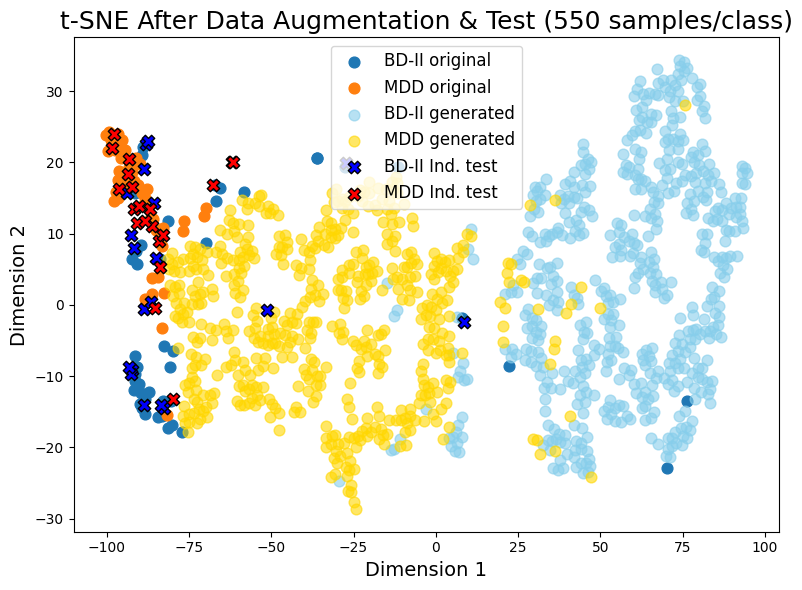

In [27]:
X_aug_best = np.vstack([X_train_final, s0, s1])
y_aug_best = np.concatenate([y_train, np.zeros(r_best), np.ones(r_best)])
X_tsne_input = np.vstack([X_aug_best, X_test_final])
y_tsne_input = np.concatenate([y_aug_best, y_test])


# Tsne2 = TSNE(n_components=2, random_state=42)
Tsne2 = TSNE(
    n_components=2,
    perplexity=20,
    learning_rate=150,
    early_exaggeration=12,
    n_iter=2000,
    n_iter_without_progress=500,
    min_grad_norm=1e-7,
    metric='cosine',
    init='random',
    method='barnes_hut',
    angle=0.3,
    random_state=42,
    verbose=1
)
X_tsne2 = Tsne2.fit_transform(X_tsne_input)


fig_tsne2, ax_tsne2 = plt.subplots(figsize=(8,6))
colors_train = {'BD_orig':'tab:blue', 'BD_syn':'skyblue', 'MDD_orig':'tab:orange', 'MDD_syn':'gold'}

n_train = len(y_train)
n_syn = 2 * r_best


start, end = 0, n_train
for label, marker, key, label_name in zip([
    0, 1
], ['o','o'], ['BD_orig','MDD_orig'], ['BD-II original','MDD original']):
    idx = (y_train == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker=marker, s=60, color=colors_train[key])


start, end = n_train, n_train + n_syn
for label, marker, key, label_name in zip([
    0, 1
], ['o','o'], ['BD_syn','MDD_syn'], ['BD-II generated','MDD generated']):
    syn_labels = y_aug_best[start:end]
    idx = (syn_labels == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker=marker, s=60, color=colors_train[key], alpha=0.6)


start, end = n_train + n_syn, n_train + n_syn + len(y_test)
for label, color, label_name in zip([0,1], ['blue','red'], ['BD-II Ind. test','MDD Ind. test']):
    test_labels = y_tsne_input[start:end]
    idx = (test_labels == label)
    pts = X_tsne2[start:end][idx]
    ax_tsne2.scatter(pts[:,0], pts[:,1], label=label_name,
                     marker='X', s=80, edgecolor='k', facecolor=color)

ax_tsne2.set_title(f"t-SNE After Data Augmentation & Test ({r_best} samples/class)", fontsize=18)
ax_tsne2.set_xlabel("Dimension 1", fontsize=14)
ax_tsne2.set_ylabel("Dimension 2", fontsize=14)
ax_tsne2.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../result/BD_MDD/DA_num/tsne_after_with_train_test.png")

##### Ind. test distribution

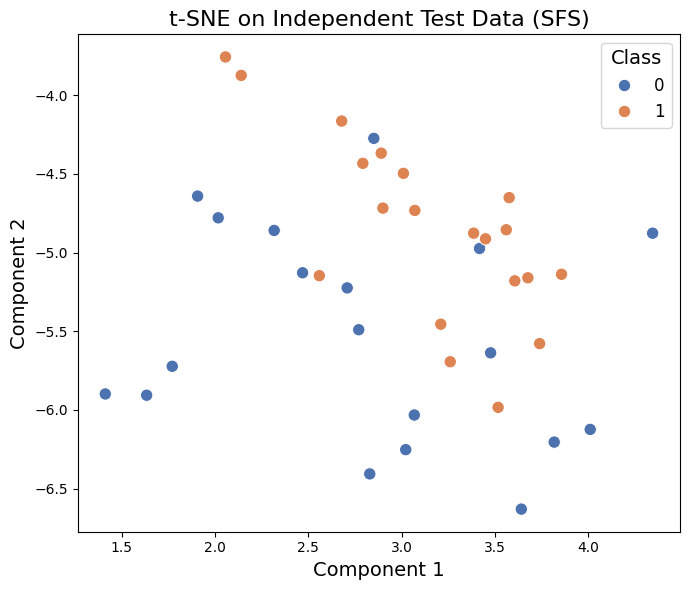

In [27]:
tsne_test = TSNE(n_components=2, random_state=42)
X_tsne_test = tsne_test.fit_transform(X_test_final)
plt.figure(figsize=(7,6))
sns.scatterplot(x=X_tsne_test[:,0], y=X_tsne_test[:,1], 
                hue=y_test.astype(int), palette="deep", s=80)
plt.title("t-SNE on Independent Test Data (SFS)", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.legend(title="Class", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.savefig("tsne_independent_test.png", dpi=300)
plt.show()